In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Objective

In this project, I aim to create a set of models to project next season performance for MLB pitchers. I will project innings pitched (IP) as well as strikeouts (SO), hits allowed (H), walks (BB), batters hit by pitch (HBP), and home runs allowed (HR) per innings pitched. 

# Data Preparation pt. 1

Models will use prior MLB pitching season data. I obtained data from 2014 through 2024 from Fangraphs.com, omitting seasons with fewer than 20 innings pitched. This gave 5631 instances. 

## Read in data

In [ ]:
# Fangraphs pitching data
fg_standard = pd.read_csv("../data/pitching/fg-pitching-standard+age.csv", index_col=["PlayerId", "Season"])
fg_advanced = pd.read_csv("../data/pitching/fg-pitching-advanced.csv", index_col=["PlayerId", "Season"]).drop(["Name", "Team", "NameASCII", "MLBAMID", "ERA"], axis=1)
fg_batted_ball = pd.read_csv("../data/pitching/fg-pitching-batted_ball.csv", index_col=["PlayerId", "Season"]).drop(["Name", "Team", "NameASCII", "MLBAMID", "BABIP"], axis=1)

# Statcast pitch-Level Data
fg_pitch_type = pd.read_csv("../data/pitching/fg-pitching-statcast-pitch_type.csv", index_col=["PlayerId", "Season"]).drop(["Name", "Team", "NameASCII", "MLBAMID", "IP"], axis=1)
fg_velocity = pd.read_csv("../data/pitching/fg-pitching-statcast-velocity.csv", index_col=["PlayerId", "Season"]).drop(["Name", "Team", "NameASCII", "MLBAMID", "IP"], axis=1)
fg_h_movement = pd.read_csv("../data/pitching/fg-pitching-statcast-h_movement.csv", index_col=["PlayerId", "Season"]).drop(["Name", "Team", "NameASCII", "MLBAMID", "IP"], axis=1)
fg_v_movement = pd.read_csv("../data/pitching/fg-pitching-statcast-v_movement.csv", index_col=["PlayerId", "Season"]).drop(["Name", "Team", "NameASCII", "MLBAMID", "IP"], axis=1)
fg_pitch_type_value = pd.read_csv("../data/pitching/fg-pitching-statcast-pitch_type_value.csv", index_col=["PlayerId", "Season"]).drop(["Name", "Team", "NameASCII", "MLBAMID", "IP"], axis=1)
fg_pitch_plate_discipline = pd.read_csv("../data/pitching/fg-pitching-statcast-plate_discipline.csv", index_col=["PlayerId", "Season"]).drop(["Name", "Team", "NameASCII", "MLBAMID", "IP"], axis=1)

## Understand and explore data

### 2020 season

The 2020 season was delayed due to the COVID-19 pandemic. Consequently...
- Only 60 games were played instead of the normal 162
- Opening day was July 23rd (avoiding the colder months that usally open the season)
- The schedule limited travel by reducing the number of opponents each team played to 9 instead of the usual ~20
- The Toronto Blue Jays played in a minor league stadium
- Doubleheaders were played as two 7 inning games

We can see the impact this has on "counting" statistics that depend on games played, such as innings pitched:

In [4]:
fg_standard.reset_index('Season').groupby('Season')['IP'].max()

Season
2014    248.1
2015    232.2
2016    230.0
2017    214.1
2018    220.2
2019    223.0
2020     84.0
2021    213.1
2022    228.2
2023    216.0
2024    208.2
Name: IP, dtype: float64

"Rate statistics" with playing time as the denominator were less impacted, though some metrics (e.g., K/9), peaked during this season. 

In [5]:
fg_advanced.reset_index('Season').groupby('Season')[['K/9', 'BB/9', 'HR/9']].mean()

,K/9,BB/9,HR/9
Season,,,
2014,7.841430,3.080955,0.861652
2015,7.857041,3.134064,1.021717
2016,8.209846,3.351837,1.197058
2017,8.387751,3.433703,1.277606
2018,8.573067,3.387305,1.163443
2019,8.936230,3.566390,1.424991
2020,9.210640,3.391966,1.245223
2021,8.991069,3.598199,1.229298
2022,8.620298,3.297522,1.084189


Also noteworthy: there were significantly fewer pitchers who surpassed the 20 inning mark in 2020...

In [6]:
fg_standard.reset_index().groupby('Season').count()['PlayerId']

Season
2014    477
2015    513
2016    512
2017    527
2018    530
2019    545
2020    323
2021    567
2022    546
2023    550
2024    541
Name: PlayerId, dtype: int64

Since my primary goal for this project is to predict rate statistics, I'm going to include instances from the 2020 season.

In [7]:
# # NOTE: This cell removes the COVID-19-shortened 2020 season from the data sets. 
# fg_standard = fg_standard[fg_standard.index.get_level_values(1) != 2020]
# fg_advanced = fg_advanced[fg_advanced.index.get_level_values(1) != 2020]
# fg_batted_ball = fg_batted_ball[fg_batted_ball.index.get_level_values(1) != 2020]
# fg_pitch_type = fg_pitch_type[fg_pitch_type.index.get_level_values(1) != 2020]
# fg_velocity = fg_velocity[fg_velocity.index.get_level_values(1) != 2020]
# fg_h_movement = fg_h_movement[fg_h_movement.index.get_level_values(1) != 2020]
# fg_v_movement = fg_v_movement[fg_v_movement.index.get_level_values(1) != 2020]
# fg_pitch_type_value = fg_pitch_type_value[fg_pitch_type_value.index.get_level_values(1) != 2020]
# fg_pitch_plate_discipline = fg_pitch_plate_discipline[fg_pitch_plate_discipline.index.get_level_values(1) != 2020]

### Fangraphs "Standard" data

These features are generally the sort you'd find on the back of a player's baseball card. They are all counting statistics with the exception of Team, Age, and ERA (Earned Run Average). 

In [8]:
fg_standard.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5631 entries, (13125, 2019) to (16155, 2019)
Data columns (total 28 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       5631 non-null   object 
 1   Team       5631 non-null   object 
 2   Age        5631 non-null   int64  
 3   W          5631 non-null   int64  
 4   L          5631 non-null   int64  
 5   ERA        5631 non-null   float64
 6   G          5631 non-null   int64  
 7   GS         5631 non-null   int64  
 8   QS         5631 non-null   int64  
 9   CG         5631 non-null   int64  
 10  ShO        5631 non-null   int64  
 11  SV         5631 non-null   int64  
 12  HLD        5631 non-null   int64  
 13  BS         5631 non-null   int64  
 14  IP         5631 non-null   float64
 15  TBF        5631 non-null   int64  
 16  H          5631 non-null   int64  
 17  R          5631 non-null   int64  
 18  ER         5631 non-null   int64  
 19  HR         5631 non-null   

In [9]:
# Standard statistics for a single player (Gerrit Cole)
fg_standard.loc[13125]

,Name,Team,Age,W,L,ERA,G,GS,QS,CG,...,ER,HR,BB,IBB,HBP,WP,BK,SO,NameASCII,MLBAMID
Season,,,,,,,,,,,,,,,,,,,,,
2019,Gerrit Cole,HOU,28,20,5,2.500785,33,33,26,0,...,59,29,48,0,3,4,3,326,Gerrit Cole,543037
2018,Gerrit Cole,HOU,27,15,5,2.875208,32,32,20,1,...,64,19,64,0,7,9,0,276,Gerrit Cole,543037
2022,Gerrit Cole,NYY,31,13,8,3.498339,33,33,21,0,...,78,33,50,0,2,2,2,257,Gerrit Cole,543037
2021,Gerrit Cole,NYY,30,16,8,3.226103,30,30,18,2,...,65,24,41,0,2,5,1,243,Gerrit Cole,543037
2023,Gerrit Cole,NYY,32,15,4,2.626794,33,33,24,2,...,61,20,48,0,7,4,1,222,Gerrit Cole,543037
2015,Gerrit Cole,PIT,24,19,8,2.596154,32,32,25,0,...,60,11,44,1,10,7,0,202,Gerrit Cole,543037
2017,Gerrit Cole,PIT,26,12,12,4.256158,33,33,20,0,...,96,31,55,1,4,7,0,196,Gerrit Cole,543037
2014,Gerrit Cole,PIT,23,11,5,3.652174,22,22,15,0,...,56,11,40,1,9,9,1,138,Gerrit Cole,543037
2024,Gerrit Cole,NYY,33,8,5,3.410526,17,17,8,0,...,36,11,29,1,6,0,0,99,Gerrit Cole,543037


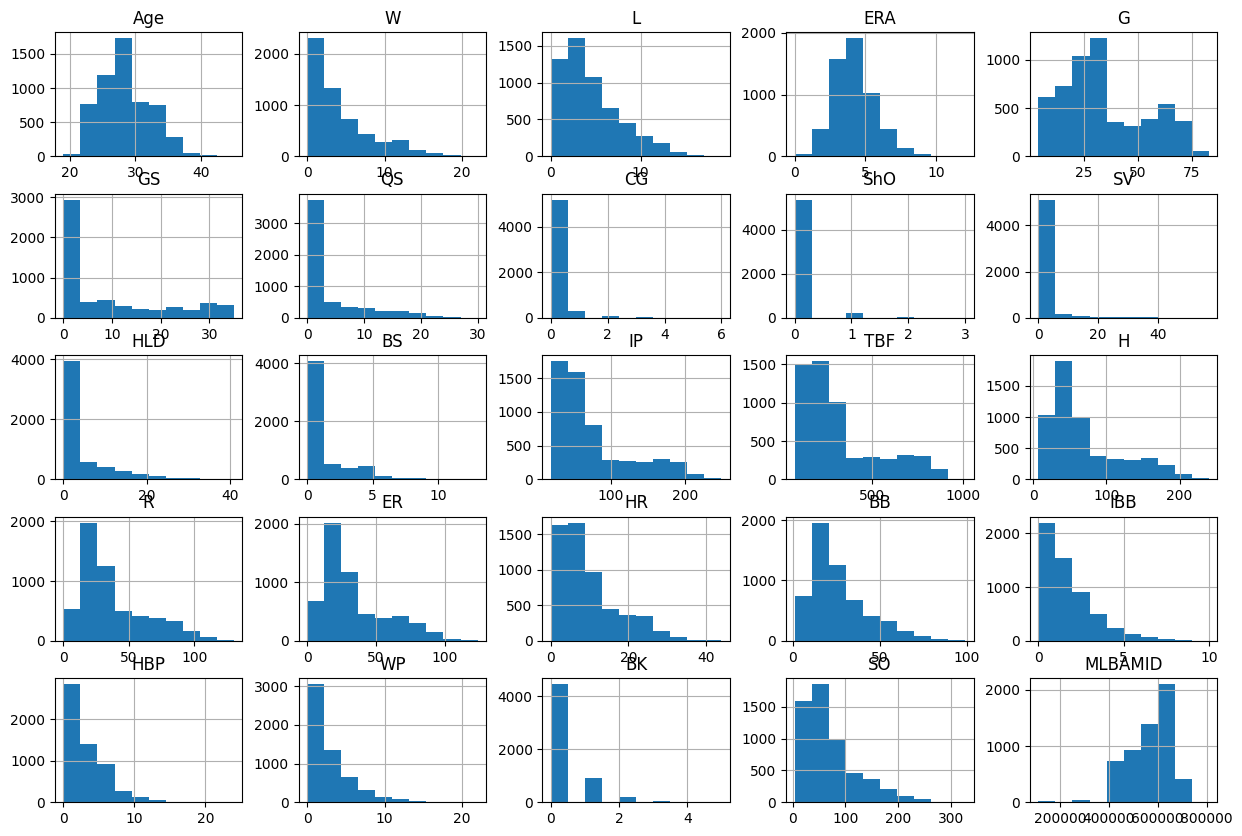

In [10]:
fg_standard.hist(bins=10, figsize=(15,10))
plt.show()

### Fangraphs "Advanced" data

- **K/9** = Strikeouts per 9 innings pitched (a regulation baseball game lasts 9 innings, so these "per 9" stats give a sense of how the pitcher would perform if he were to pitch a complete game)
- **BB/9** = Walks per 9 innings 
- **K/BB** = Strikeout to walk ratio
- **HR/9** == Home runs per 9 innings
- **K%** = Strikeout percentage (K/TBF)
- **BB%** = Walk percentage (BB/TBF)
- **K-BB%** = Strikeout percentage minus walk percentage 
- **AVG** = Batting average against 
- **WHIP** = *W*alks plus *H*its divided by *I*nnings *P*itched (W+H/IP) 
- **BABIP** = Batting average on balls in play 
- **LOB%** = Left on base percentage 
- **ERA-** = ERA adjusted for park and league (100 is average, lower is better)
- **FIP-** = FIP adjusted for park and league (100 is average, lower is better)
- **xFIP-** = xFIP adjusted by league (100 is average, lower is better)
- **FIP** = [Fielder Independent Pitching](https://library.fangraphs.com/pitching/fip/) (on ERA scale)
- **E-F** = ERA - FIP
- **xFIP** = [Expected Fielder Independent Pitching](https://library.fangraphs.com/pitching/xfip/)
- **SIERA** = [Skill Interactive ERA](https://library.fangraphs.com/pitching/siera/)

In [11]:
fg_advanced.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5631 entries, (1118, 2019) to (12803, 2015)
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   K/9     5631 non-null   float64
 1   BB/9    5631 non-null   float64
 2   K/BB    5631 non-null   float64
 3   HR/9    5631 non-null   float64
 4   K%      5631 non-null   float64
 5   BB%     5631 non-null   float64
 6   K-BB%   5631 non-null   float64
 7   AVG     5631 non-null   float64
 8   WHIP    5631 non-null   float64
 9   BABIP   5631 non-null   float64
 10  LOB%    5631 non-null   float64
 11  ERA-    5631 non-null   float64
 12  FIP-    5631 non-null   float64
 13  xFIP-   5631 non-null   float64
 14  FIP     5631 non-null   float64
 15  E-F     5631 non-null   float64
 16  xFIP    5631 non-null   float64
 17  SIERA   5631 non-null   float64
dtypes: float64(18)
memory usage: 886.4 KB


In [12]:
fg_advanced.describe()

,K/9,BB/9,K/BB,HR/9,K%,BB%,K-BB%,AVG,WHIP,BABIP,LOB%,ERA-,FIP-,xFIP-,FIP,E-F,xFIP,SIERA
count,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000
mean,8.539897,3.363984,2.913498,1.168058,0.223299,0.086617,0.136682,0.243522,1.320223,0.291874,0.729382,100.927469,100.928375,101.169162,4.217464,0.003009,4.226955,4.057625
std,2.107654,1.230491,1.505094,0.582648,0.059757,0.028917,0.065065,0.039689,0.245037,0.041700,0.078378,34.775832,25.876670,19.100362,1.113181,1.007110,0.829936,0.815448
min,1.714286,0.321429,0.444444,0.000000,0.039604,0.008475,-0.067227,0.086420,0.493151,0.104167,0.340909,0.000000,19.680518,24.916582,0.858086,-3.837573,1.037783,0.865243
25%,7.090909,2.481920,2.000000,0.771429,0.181818,0.066327,0.091609,0.217822,1.158062,0.266667,0.680690,77.269945,84.030831,88.870601,3.485958,-0.615973,3.679527,3.530735
50%,8.386365,3.214286,2.590909,1.102041,0.217514,0.083721,0.132231,0.243697,1.304038,0.291866,0.731132,97.246056,99.096492,101.043635,4.129068,-0.070614,4.197746,4.063046
75%,9.865386,4.085317,3.444444,1.467391,0.259632,0.103896,0.176770,0.269663,1.466479,0.317365,0.779628,120.527457,115.917014,113.287987,4.835232,0.553299,4.760018,4.594452
max,17.666670,9.084113,25.000000,4.984617,0.530000,0.213270,0.440945,0.400000,2.373913,0.474820,1.000000,279.164374,232.655260,181.359201,9.849683,6.087109,8.301602,7.286938


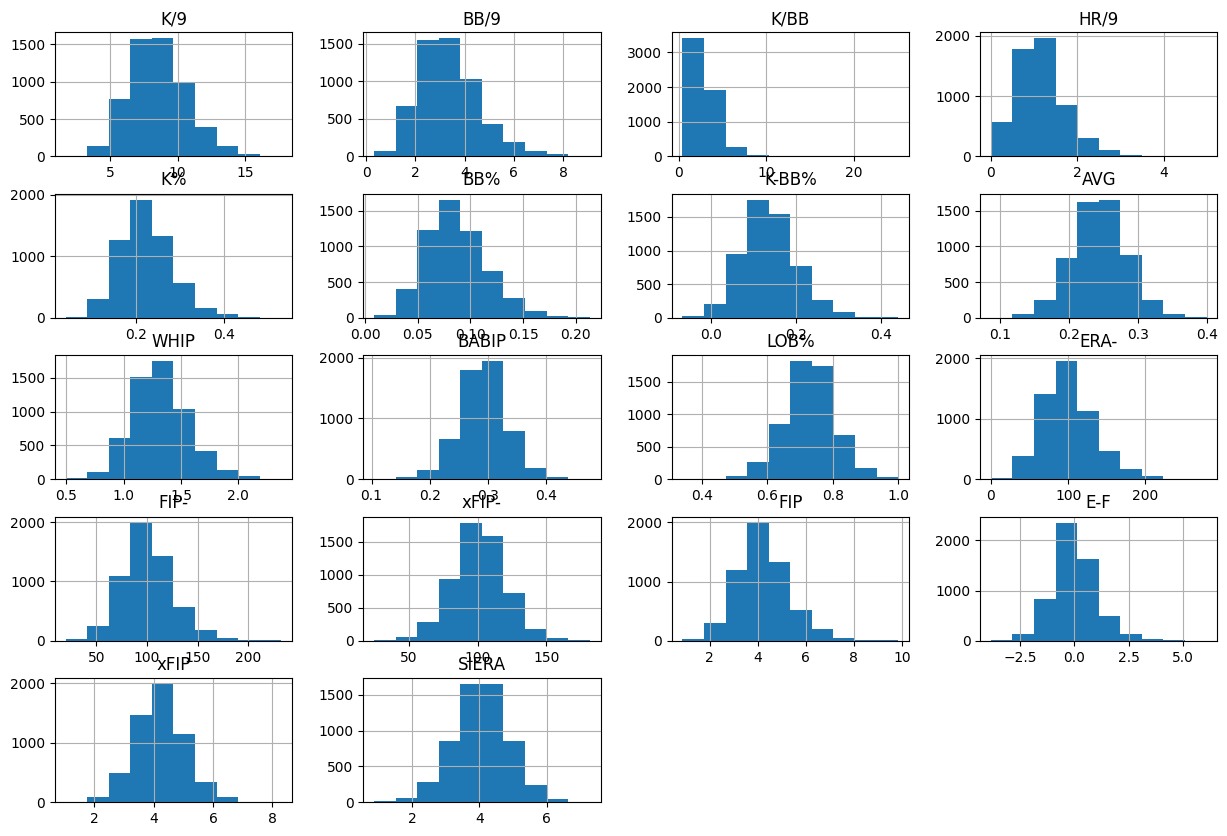

In [13]:
fg_advanced.hist(bins=10, figsize=(15,10))
plt.show()

In [14]:
fg_advanced.reset_index('Season').groupby('Season')[['K/9', 'BB/9']].mean()

,K/9,BB/9
Season,,
2014,7.841430,3.080955
2015,7.857041,3.134064
2016,8.209846,3.351837
2017,8.387751,3.433703
2018,8.573067,3.387305
2019,8.936230,3.566390
2020,9.210640,3.391966
2021,8.991069,3.598199
2022,8.620298,3.297522


### FanGraphs Batted Ball data

Staatistics describing the sort of contact batters make with pitches.

In [15]:
fg_batted_ball.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5631 entries, (12183, 2019) to (14741, 2017)
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GB/FB    5631 non-null   float64
 1   LD%      5631 non-null   float64
 2   GB%      5631 non-null   float64
 3   FB%      5631 non-null   float64
 4   IFFB%    5631 non-null   float64
 5   HR/FB    5631 non-null   float64
 6   RS       5631 non-null   int64  
 7   RS/9     5631 non-null   float64
 8   Balls    5631 non-null   int64  
 9   Strikes  5631 non-null   int64  
 10  Pitches  5631 non-null   int64  
 11  Pull%    5631 non-null   float64
 12  Cent%    5631 non-null   float64
 13  Oppo%    5631 non-null   float64
 14  Soft%    5631 non-null   float64
 15  Med%     5631 non-null   float64
 16  Hard%    5631 non-null   float64
dtypes: float64(13), int64(4)
memory usage: 842.4 KB


In [16]:
fg_batted_ball.describe()

,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,RS,RS/9,Balls,Strikes,Pitches,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%
count,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000,5631.000000
mean,1.332945,0.204957,0.433065,0.361978,0.097537,0.125080,37.891849,4.395174,445.536494,791.586042,1237.122536,0.399596,0.347611,0.252794,0.175113,0.504943,0.319944
std,0.679064,0.035821,0.084852,0.083104,0.045964,0.053003,30.436496,1.525631,288.901110,526.847009,812.401334,0.053754,0.041414,0.046184,0.039112,0.051792,0.055373
min,0.214286,0.025641,0.136364,0.079646,0.000000,0.000000,0.000000,0.000000,70.000000,163.000000,233.000000,0.180723,0.144737,0.071429,0.037037,0.295082,0.096154
25%,0.906630,0.182927,0.375743,0.305165,0.068182,0.090909,16.000000,3.437975,232.000000,400.000000,635.000000,0.364475,0.322314,0.222958,0.148936,0.472565,0.283515
50%,1.189055,0.205128,0.430464,0.361111,0.095238,0.120370,28.000000,4.378380,351.000000,630.000000,979.000000,0.400000,0.346457,0.250000,0.173554,0.506667,0.316832
75%,1.575758,0.225661,0.486111,0.414894,0.125000,0.153846,50.000000,5.307472,572.000000,1015.000000,1579.500000,0.434783,0.372927,0.281081,0.199438,0.539683,0.355070
max,9.142857,0.393617,0.800000,0.662651,0.285714,0.470588,189.000000,16.831177,1369.000000,2600.000000,3730.000000,0.626374,0.514706,0.448980,0.349057,0.730769,0.545455


In [17]:
fg_batted_ball.head()

,,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,RS,RS/9,Balls,Strikes,Pitches,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%
PlayerId,Season,,,,,,,,,,,,,,,,,
12183,2019,0.302326,0.151515,0.196970,0.651515,0.116279,0.209302,5,1.956523,208,283,491,0.287879,0.439394,0.272727,0.136364,0.318182,0.545455
7450,2018,0.607843,0.240741,0.287037,0.472222,0.019608,0.215686,19,5.234694,191,371,562,0.385321,0.348624,0.266055,0.091743,0.366972,0.541284
17998,2019,1.444444,0.266667,0.433333,0.300000,0.055556,0.277778,9,3.857143,139,248,387,0.442623,0.311475,0.245902,0.180328,0.295082,0.524590
1246,2018,1.434783,0.232877,0.452055,0.315068,0.130435,0.130435,14,5.478261,167,247,414,0.315068,0.246575,0.438356,0.136986,0.342466,0.520548
13549,2020,1.000000,0.215686,0.392157,0.392157,0.050000,0.150000,12,4.628572,136,256,392,0.313725,0.431373,0.254902,0.117647,0.372549,0.509804


### Statcast Pitch Type data

*NOTE: Every instance in this data set will have a NA (since no pitcher throws all pitch types).*

In [18]:
fg_pitch_type.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5631 entries, (18, 2014) to (33876, 2024)
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FA%     5384 non-null   float64
 1   FT%     0 non-null      float64
 2   FC%     1978 non-null   float64
 3   FS%     599 non-null    float64
 4   FO%     9 non-null      float64
 5   SI%     4291 non-null   float64
 6   SL%     4516 non-null   float64
 7   CU%     3206 non-null   float64
 8   KC%     666 non-null    float64
 9   EP%     44 non-null     float64
 10  CH%     4525 non-null   float64
 11  SC%     10 non-null     float64
 12  KN%     13 non-null     float64
 13  UN%     0 non-null      float64
dtypes: float64(14)
memory usage: 710.5 KB


In [19]:
fg_pitch_type.describe()

,FA%,FT%,FC%,FS%,FO%,SI%,SL%,CU%,KC%,EP%,CH%,SC%,KN%,UN%
count,5384.000000,0.0,1978.000000,599.000000,9.000000,4291.000000,4516.000000,3206.000000,666.000000,44.000000,4525.000000,10.000000,13.000000,0.0
mean,0.367085,NaN,0.179283,0.159376,0.183816,0.236520,0.236872,0.132400,0.173385,0.013292,0.125846,0.042426,0.602910,NaN
std,0.194887,NaN,0.156822,0.126876,0.108127,0.197564,0.139273,0.100031,0.122252,0.020256,0.099032,0.072068,0.324374,NaN
min,0.000364,NaN,0.000296,0.000312,0.000592,0.000297,0.000303,0.000321,0.000342,0.000301,0.000308,0.000335,0.000337,NaN
25%,0.224910,NaN,0.052460,0.056800,0.166337,0.065484,0.136628,0.056815,0.079250,0.001246,0.045714,0.003105,0.381633,NaN
50%,0.387557,NaN,0.155710,0.144431,0.237191,0.198570,0.226782,0.114950,0.161342,0.004580,0.108069,0.014177,0.742775,NaN
75%,0.513742,NaN,0.256480,0.234217,0.253550,0.366164,0.321912,0.188216,0.250731,0.014528,0.184442,0.038985,0.817299,NaN
max,0.963855,NaN,0.891683,0.680899,0.277372,0.917485,0.913218,0.716157,0.562500,0.089793,0.757664,0.235392,0.872573,NaN


In [20]:
fg_pitch_type.head()

,,FA%,FT%,FC%,FS%,FO%,SI%,SL%,CU%,KC%,EP%,CH%,SC%,KN%,UN%
PlayerId,Season,,,,,,,,,,,,,,
18,2014,0.665975,NaN,NaN,NaN,NaN,0.035270,0.172199,NaN,NaN,NaN,0.126556,NaN,NaN,NaN
126,2014,0.388690,NaN,0.016464,0.089477,NaN,0.156765,NaN,0.229778,NaN,NaN,0.118826,NaN,NaN,NaN
225,2014,0.212849,NaN,0.125892,NaN,NaN,0.276119,NaN,0.130110,NaN,NaN,0.255029,NaN,NaN,NaN
278,2014,0.387234,NaN,0.002128,NaN,NaN,0.223404,0.234043,0.002128,NaN,NaN,0.151064,NaN,NaN,NaN
375,2014,0.285619,NaN,NaN,NaN,NaN,0.535202,0.122789,NaN,NaN,NaN,0.056390,NaN,NaN,NaN


### Statcast Pitch Value data

Run values by pitch type - http://tangotiger.com/index.php/site/article/run-values-by-pitch-count

In [21]:
fg_pitch_type_value.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5631 entries, (1245, 2015) to (33876, 2024)
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wFA     5384 non-null   float64
 1   wFT     0 non-null      float64
 2   wFC     1978 non-null   float64
 3   wFS     599 non-null    float64
 4   wFO     9 non-null      float64
 5   wSI     4291 non-null   float64
 6   wSL     4516 non-null   float64
 7   wCU     3206 non-null   float64
 8   wKC     666 non-null    float64
 9   wEP     44 non-null     float64
 10  wCH     4525 non-null   float64
 11  wSC     10 non-null     float64
 12  wKN     13 non-null     float64
dtypes: float64(13)
memory usage: 666.5 KB


In [22]:
fg_pitch_type_value.describe()

,wFA,wFT,wFC,wFS,wFO,wSI,wSL,wCU,wKC,wEP,wCH,wSC,wKN
count,5384.000000,0.0,1978.000000,599.000000,9.000000,4291.000000,4516.000000,3206.000000,666.000000,44.000000,4525.000000,10.000000,13.000000
mean,0.161091,NaN,0.677570,0.966381,-0.177213,0.228937,1.299412,0.073830,0.773259,0.001828,0.174896,-0.469929,-1.518538
std,5.856122,NaN,4.108951,3.877696,2.664135,4.634253,4.748756,3.482389,4.217442,1.308017,3.606645,1.575114,7.774713
min,-26.411414,NaN,-13.672606,-13.056010,-3.124468,-24.567847,-20.971340,-12.533481,-14.754140,-4.643168,-14.722349,-3.084039,-16.511230
25%,-2.877193,NaN,-1.290380,-1.119480,-1.503989,-1.805907,-1.319269,-1.594279,-1.342445,-0.173970,-1.552764,-0.874902,-1.894330
50%,-0.051225,NaN,0.069242,0.163725,-0.063374,-0.000494,0.483142,-0.112047,0.059697,0.001045,-0.097424,-0.303918,-0.851215
75%,2.712641,NaN,2.074549,2.433743,0.022515,1.967624,3.337731,1.115075,2.204039,0.338573,1.238707,-0.022890,1.325142
max,36.090017,NaN,27.164979,21.633555,6.285026,25.987092,35.110895,39.842017,23.262079,5.265346,28.848361,2.714307,11.920722


### Statcast Pitch Velocity data

Average speed of pitches thrown.

- vFA
- vFT
- vFC
- vFS
- vFO
- vSI
- vSL
- vCU
- vKC
- vEP
- vCH
- vSC
- vKN

In [23]:
fg_velocity.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5631 entries, (25550, 2024) to (33876, 2024)
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   vFA     5384 non-null   float64
 1   vFT     0 non-null      float64
 2   vFC     1978 non-null   float64
 3   vFS     599 non-null    float64
 4   vFO     9 non-null      float64
 5   vSI     4291 non-null   float64
 6   vSL     4516 non-null   float64
 7   vCU     3206 non-null   float64
 8   vKC     666 non-null    float64
 9   vEP     44 non-null     float64
 10  vCH     4525 non-null   float64
 11  vSC     10 non-null     float64
 12  vKN     13 non-null     float64
dtypes: float64(13)
memory usage: 666.5 KB


In [24]:
fg_velocity.describe()

,vFA,vFT,vFC,vFS,vFO,vSI,vSL,vCU,vKC,vEP,vCH,vSC,vKN
count,5384.000000,0.0,1978.000000,599.000000,9.000000,4291.000000,4516.000000,3206.000000,666.000000,44.000000,4525.000000,10.000000,13.000000
mean,93.119405,NaN,88.685173,85.756503,84.377475,92.576053,84.202852,78.108772,79.252514,62.385844,85.165703,79.929076,75.583745
std,2.590813,NaN,2.793659,3.032983,3.720851,2.699733,3.128696,3.582191,4.689452,6.677206,3.279581,2.492384,1.280975
min,80.584011,NaN,79.352644,76.800003,76.400002,78.913206,46.599998,51.799999,53.900002,45.299999,63.033335,76.938462,73.613071
25%,91.572788,NaN,86.775133,83.942408,83.232327,90.849264,82.203155,75.816836,77.552242,58.093751,83.307427,78.579289,74.611355
50%,93.243555,NaN,88.599727,85.759998,86.336905,92.666667,84.426201,78.293828,79.889632,63.745454,85.363957,79.302564,75.931296
75%,94.825000,NaN,90.491112,87.642680,86.997145,94.424497,86.383306,80.609573,82.002246,65.695183,87.415382,80.458323,76.504923
max,102.095142,NaN,100.220652,98.356115,87.676000,101.449997,97.949997,88.699997,89.376858,81.253850,95.900002,85.206665,77.589200


In [25]:
fg_velocity.head()

vFA  vFT        vFC  vFS  vFO        vSI        vSL  \
PlayerId Season                                                              
25550    2024    90.624303  NaN  87.035073  NaN  NaN  90.015866  79.286006   
1245     2017    83.618444  NaN        NaN  NaN  NaN        NaN        NaN   
25550    2023    91.283334  NaN  86.684088  NaN  NaN  91.319496  79.777780   
1245     2014    81.779041  NaN        NaN  NaN  NaN        NaN        NaN   
         2015    81.703890  NaN        NaN  NaN  NaN        NaN        NaN   

                 vCU  vKC        vEP  vCH  vSC        vKN  
PlayerId Season                                            
25550    2024    NaN  NaN        NaN  NaN  NaN  77.589200  
1245     2017    NaN  NaN  65.941176  NaN  NaN  77.278573  
25550    2023    NaN  NaN        NaN  NaN  NaN  76.591667  
1245     2014    NaN  NaN  65.613185  NaN  NaN  76.504923  
         2015    NaN  NaN  64.411540  NaN  NaN  76.226266

Something interesting this data reveals: increasing fastball velocity...

In [26]:
fg_velocity['vFA'].groupby('Season').mean().sort_index(ascending=False)

Season
2024    94.065958
2023    93.993928
2022    93.836183
2021    93.520803
2020    93.206244
2019    93.215243
2018    92.924391
2017    92.946531
2016    92.385841
2015    92.103088
2014    91.910871
Name: vFA, dtype: float64

### Statcast Pitch Movement - Horizontal data

In [27]:
fg_h_movement.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5631 entries, (8185, 2014) to (33876, 2024)
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FA-X    5384 non-null   float64
 1   FT-X    0 non-null      float64
 2   FC-X    1978 non-null   float64
 3   FS-X    599 non-null    float64
 4   FO-X    9 non-null      float64
 5   SI-X    4291 non-null   float64
 6   SL-X    4516 non-null   float64
 7   CU-X    3206 non-null   float64
 8   KC-X    666 non-null    float64
 9   EP-X    44 non-null     float64
 10  CH-X    4525 non-null   float64
 11  SC-X    10 non-null     float64
 12  KN-X    13 non-null     float64
dtypes: float64(13)
memory usage: 666.5 KB


In [28]:
fg_h_movement.describe()

,FA-X,FT-X,FC-X,FS-X,FO-X,SI-X,SL-X,CU-X,KC-X,EP-X,CH-X,SC-X,KN-X
count,5384.000000,0.0,1978.000000,599.000000,9.000000,4291.000000,4516.000000,3206.000000,666.000000,44.000000,4525.000000,10.000000,13.000000
mean,-2.087163,NaN,0.614718,-5.041280,-6.549945,-3.755752,1.486300,2.241540,2.619823,1.066977,-3.170390,1.532615,-1.107949
std,4.840737,NaN,1.711316,4.287255,1.524954,7.975739,3.450170,4.629701,3.758323,5.239234,7.574884,7.881665,1.609438
min,-13.733540,NaN,-8.807585,-14.522919,-9.239216,-36.655518,-12.299675,-10.687946,-10.076509,-10.103408,-18.134222,-6.920000,-3.814806
25%,-5.583829,NaN,-0.401949,-7.544047,-7.227709,-9.220879,-0.317134,-1.310129,0.578199,-3.201453,-8.725989,-5.683585,-2.539000
50%,-3.830915,NaN,0.709871,-6.233622,-6.290238,-7.925053,1.597169,3.419367,3.429478,0.846047,-7.026306,1.060031,-0.617443
75%,1.572045,NaN,1.672404,-4.421093,-5.737056,6.700372,3.309772,5.714024,5.256416,5.545365,6.470624,8.678106,0.007002
max,12.037272,NaN,9.158348,9.141361,-4.462862,16.632357,12.533202,19.490592,10.653749,10.410000,48.517631,11.231538,1.170272


In [29]:
fg_h_movement.head()

FA-X  FT-X  FC-X  FS-X  FO-X  SI-X  SL-X      CU-X  KC-X  \
PlayerId Season                                                                 
8185     2014   -4.433962   NaN   NaN   NaN   NaN   NaN   NaN  2.419445   NaN   
         2016   -4.963647   NaN   NaN   NaN   NaN   NaN   NaN  2.729325   NaN   
         2015   -5.407561   NaN   NaN   NaN   NaN   NaN   NaN  1.000437   NaN   
1245     2014   -7.052059   NaN   NaN   NaN   NaN   NaN   NaN       NaN   NaN   
         2016   -7.930516   NaN   NaN   NaN   NaN   NaN   NaN       NaN   NaN   

                     EP-X  CH-X  SC-X      KN-X  
PlayerId Season                                  
8185     2014         NaN   NaN   NaN  1.170272  
         2016         NaN   NaN   NaN  0.744092  
         2015         NaN   NaN   NaN  0.466067  
1245     2014    1.470203   NaN   NaN  0.007002  
         2016   -0.748816   NaN   NaN -0.464834

### Statcast Pitch Movement - Vertical data

In [30]:
fg_v_movement.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5631 entries, (25436, 2024) to (33876, 2024)
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FA-Z    5384 non-null   float64
 1   FT-Z    0 non-null      float64
 2   FC-Z    1978 non-null   float64
 3   FS-Z    599 non-null    float64
 4   FO-Z    9 non-null      float64
 5   SI-Z    4291 non-null   float64
 6   SL-Z    4516 non-null   float64
 7   CU-Z    3206 non-null   float64
 8   KC-Z    666 non-null    float64
 9   EP-Z    44 non-null     float64
 10  CH-Z    4525 non-null   float64
 11  SC-Z    10 non-null     float64
 12  KN-Z    13 non-null     float64
dtypes: float64(13)
memory usage: 666.5 KB


### Statcast Plate Discipline data

In [31]:
fg_pitch_plate_discipline.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5631 entries, (4185, 2020) to (8779, 2023)
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   O-Swing%    5631 non-null   float64
 1   Z-Swing%    5631 non-null   float64
 2   Swing%      5631 non-null   float64
 3   O-Contact%  5631 non-null   float64
 4   Z-Contact%  5631 non-null   float64
 5   Contact%    5631 non-null   float64
 6   Zone%       5631 non-null   float64
 7   Pace        5631 non-null   float64
dtypes: float64(8)
memory usage: 446.5 KB


##  Feature engineering

### fg_standard

In [32]:
fg_standard.head()

,,Name,Team,Age,W,L,ERA,G,GS,QS,CG,...,ER,HR,BB,IBB,HBP,WP,BK,SO,NameASCII,MLBAMID
PlayerId,Season,,,,,,,,,,,,,,,,,,,,,
13125,2019,Gerrit Cole,HOU,28,20,5,2.500785,33,33,26,0,...,59,29,48,0,3,4,3,326,Gerrit Cole,543037
10603,2017,Chris Sale,BOS,28,17,8,2.897356,32,32,23,1,...,69,24,43,0,8,3,0,308,Chris Sale,519242
2036,2015,Clayton Kershaw,LAD,27,16,7,2.127507,33,33,27,4,...,55,15,42,1,5,9,3,301,Clayton Kershaw,477132
3137,2018,Max Scherzer,WSN,33,18,7,2.528701,33,33,28,2,...,62,23,51,4,12,4,1,300,Max Scherzer,453286
8700,2019,Justin Verlander,HOU,36,21,6,2.582960,34,34,26,2,...,64,36,42,0,6,4,0,300,Justin Verlander,434378


In [33]:
# per IP stats for SO, H, BB, HBP, HR
fg_standard['SO/IP'] = fg_standard['SO'] / fg_standard['IP']
fg_standard['H/IP'] = fg_standard['H'] / fg_standard['IP']
fg_standard['BB/IP'] = fg_standard['BB'] / fg_standard['IP']
fg_standard['HBP/IP'] = fg_standard['HBP'] / fg_standard['IP']
fg_standard['HR/IP'] = fg_standard['HR'] / fg_standard['IP']

In [34]:
# rolling avgs for per IP stats 
fg_standard['avg_IP'] = fg_standard.groupby('PlayerId')['IP'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
fg_standard['avg_SO/IP'] = fg_standard.groupby('PlayerId')['SO/IP'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
fg_standard['avg_H/IP'] = fg_standard.groupby('PlayerId')['H/IP'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
fg_standard['avg_BB/IP'] = fg_standard.groupby('PlayerId')['BB/IP'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
fg_standard['avg_HBP/IP'] = fg_standard.groupby('PlayerId')['HBP/IP'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
fg_standard['avg_HR/IP'] = fg_standard.groupby('PlayerId')['HR/IP'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)

### fg_advanced

In [35]:
fg_advanced

,,K/9,BB/9,K/BB,HR/9,K%,BB%,K-BB%,AVG,WHIP,BABIP,LOB%,ERA-,FIP-,xFIP-,FIP,E-F,xFIP,SIERA
PlayerId,Season,,,,,,,,,,,,,,,,,,
1118,2019,4.183100,3.042254,1.375000,2.661973,0.103774,0.075472,0.028302,0.242105,1.309860,0.207792,0.619835,153.934449,167.975034,180.697876,7.523870,-0.678798,8.301602,7.286938
16155,2019,1.714286,3.857143,0.444444,2.142857,0.039604,0.089109,-0.049505,0.329670,1.857143,0.304878,0.575758,190.764117,163.011537,169.105995,7.356867,1.643133,7.766420,7.262680
29833,2024,6.560748,9.084113,0.722222,1.766355,0.149425,0.206897,-0.057471,0.233577,1.906542,0.240385,0.608108,174.458083,175.558592,181.359201,7.372087,-0.306667,7.364251,7.182650
15734,2023,6.154412,8.933825,0.688889,0.595588,0.146919,0.213270,-0.066351,0.257669,1.919118,0.302326,0.745921,101.965836,138.198953,149.727882,5.924158,-1.357981,6.413291,7.108541
17594,2020,6.646153,7.476922,0.888889,1.661538,0.183908,0.206897,-0.022989,0.132353,1.246154,0.104167,0.937500,64.997880,150.101788,147.179749,6.745265,-3.837573,6.570205,6.937591
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14710,2022,17.129034,2.612904,6.555556,0.435484,0.502128,0.076596,0.425532,0.158140,0.838710,0.329787,0.903614,33.649920,23.928503,27.113908,0.902753,0.403698,1.037783,1.106676
6785,2016,14.892377,1.089686,13.666667,0.968610,0.447273,0.032727,0.414545,0.159091,0.686099,0.255639,0.956938,33.714287,37.851261,27.022273,1.680193,-0.227278,1.177377,1.104041
10233,2014,17.666670,4.000001,4.416667,0.166667,0.524752,0.118812,0.405941,0.119318,0.833334,0.289855,0.767544,53.886886,22.809653,31.956364,0.891511,1.108489,1.200085,1.089425


### fg_batted_ball

In [36]:
fg_batted_ball

,,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,RS,RS/9,Balls,Strikes,Pitches,Pull%,Cent%,Oppo%,Soft%,Med%,Hard%
PlayerId,Season,,,,,,,,,,,,,,,,,
12183,2019,0.302326,0.151515,0.196970,0.651515,0.116279,0.209302,5,1.956523,208,283,491,0.287879,0.439394,0.272727,0.136364,0.318182,0.545455
7450,2018,0.607843,0.240741,0.287037,0.472222,0.019608,0.215686,19,5.234694,191,371,562,0.385321,0.348624,0.266055,0.091743,0.366972,0.541284
17998,2019,1.444444,0.266667,0.433333,0.300000,0.055556,0.277778,9,3.857143,139,248,387,0.442623,0.311475,0.245902,0.180328,0.295082,0.524590
1246,2018,1.434783,0.232877,0.452055,0.315068,0.130435,0.130435,14,5.478261,167,247,414,0.315068,0.246575,0.438356,0.136986,0.342466,0.520548
13549,2020,1.000000,0.215686,0.392157,0.392157,0.050000,0.150000,12,4.628572,136,256,392,0.313725,0.431373,0.254902,0.117647,0.372549,0.509804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3240,2016,9.142857,0.112500,0.800000,0.087500,0.000000,0.071429,5,0.671642,376,651,1027,0.419753,0.401235,0.179012,0.308642,0.543210,0.148148
13346,2017,1.303030,0.200000,0.452632,0.347368,0.151515,0.060606,16,4.595746,213,329,542,0.340206,0.319588,0.340206,0.319588,0.536082,0.144330
17295,2018,4.266667,0.131868,0.703297,0.164835,0.133333,0.200000,21,5.108109,278,355,633,0.478261,0.271739,0.250000,0.217391,0.641304,0.141304


### fg_pitch_type

In [37]:
# Number of pitches
fg_pitch_type["num_pitches"] = fg_pitch_type.notna().sum(axis=1)

# Number of fastballs
fg_pitch_type["num_fastballs"] = fg_pitch_type[['FA%', 'FT%', 'FC%', 'FS%']].notna().sum(axis=1)

In [38]:
fg_pitch_type.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5631 entries, (18, 2014) to (33876, 2024)
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FA%            5384 non-null   float64
 1   FT%            0 non-null      float64
 2   FC%            1978 non-null   float64
 3   FS%            599 non-null    float64
 4   FO%            9 non-null      float64
 5   SI%            4291 non-null   float64
 6   SL%            4516 non-null   float64
 7   CU%            3206 non-null   float64
 8   KC%            666 non-null    float64
 9   EP%            44 non-null     float64
 10  CH%            4525 non-null   float64
 11  SC%            10 non-null     float64
 12  KN%            13 non-null     float64
 13  UN%            0 non-null      float64
 14  num_pitches    5631 non-null   int64  
 15  num_fastballs  5631 non-null   int64  
dtypes: float64(14), int64(2)
memory usage: 798.4 KB


### fg_pitch_type_value

In [39]:
fg_pitch_type_value

wFA  wFT       wFC        wFS  wFO       wSI       wSL  \
PlayerId Season                                                                 
1245     2015    -3.731577  NaN       NaN        NaN  NaN       NaN       NaN   
8185     2018     0.691758  NaN       NaN        NaN  NaN  0.009769       NaN   
         2016     7.283477  NaN       NaN        NaN  NaN       NaN       NaN   
         2015     2.137187  NaN       NaN        NaN  NaN       NaN       NaN   
25436    2023    14.851745  NaN       NaN   1.832700  NaN  2.616512  5.730240   
...                    ...  ...       ...        ...  ...       ...       ...   
33825    2024     4.561214  NaN  0.247966   0.878504  NaN -0.691926  0.258887   
33826    2024     1.341997  NaN       NaN   0.651390  NaN       NaN  2.925098   
33829    2024     4.798841  NaN -0.755426  11.034310  NaN  0.413262  0.275865   
33838    2024    -0.758190  NaN       NaN  -1.688674  NaN  4.828251  2.837765   
33876    2024    -0.339056  NaN       NaN        NaN  NaN  4.101038  0.651391   

                      wCU       wKC       wEP       wCH  wSC        wKN  
PlayerId Season                                                          
1245     2015         NaN       NaN -1.123738       NaN  NaN  11.920722  
8185     2018    0.329252       NaN       NaN       NaN  NaN   6.186666  
         2016    4.163627       NaN       NaN       NaN  NaN   5.877186  
         2015   -5.000616       NaN       NaN       NaN  NaN   1.325142  
25436    2023         NaN  1.148352       NaN -2.707059  NaN   0.005185  
...                   ...       ...       ...       ...  ...        ...  
33825    2024    3.883197       NaN       NaN       NaN  NaN        NaN  
33826    2024    0.234524       NaN       NaN       NaN  NaN        NaN  
33829    2024   -0.496073 -0.765533       NaN  0.476748  NaN        NaN  
33838    2024   -4.471426       NaN       NaN       NaN  NaN        NaN  
33876    2024         NaN       NaN       NaN  1.294402  NaN        NaN  

[5631 rows x 13 columns]

In [40]:
# Number of positively valued pitches
fg_pitch_type_value["num_good_pitches"] = fg_pitch_type_value[fg_pitch_type_value > 0].count(axis=1)

# Total pitch value
fg_pitch_type_value["total_pitch_value"] = fg_pitch_type_value.sum(axis=1)

# Avg pitch value
fg_pitch_type_value["avg_pitch_value"] = fg_pitch_type_value.mean(axis=1)

In [41]:
fg_pitch_type_value.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5631 entries, (1245, 2015) to (33876, 2024)
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wFA                5384 non-null   float64
 1   wFT                0 non-null      float64
 2   wFC                1978 non-null   float64
 3   wFS                599 non-null    float64
 4   wFO                9 non-null      float64
 5   wSI                4291 non-null   float64
 6   wSL                4516 non-null   float64
 7   wCU                3206 non-null   float64
 8   wKC                666 non-null    float64
 9   wEP                44 non-null     float64
 10  wCH                4525 non-null   float64
 11  wSC                10 non-null     float64
 12  wKN                13 non-null     float64
 13  num_good_pitches   5631 non-null   int64  
 14  total_pitch_value  5631 non-null   float64
 15  avg_pitch_value    5631 non-null   float64
dtypes: f

### fg_velocity

In [42]:
# Min & max velo
max_velo = fg_velocity.max(axis=1)
min_velo = fg_velocity.min(axis=1)
fg_velocity["max_velo"] = max_velo
fg_velocity["min_velo"] = min_velo

# Difference between fastest and slowest pitch
fg_velocity["diff_max_velo"] = fg_velocity.max(axis=1) - fg_velocity.min(axis=1)

In [43]:
fg_velocity.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5631 entries, (25550, 2024) to (33876, 2024)
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   vFA            5384 non-null   float64
 1   vFT            0 non-null      float64
 2   vFC            1978 non-null   float64
 3   vFS            599 non-null    float64
 4   vFO            9 non-null      float64
 5   vSI            4291 non-null   float64
 6   vSL            4516 non-null   float64
 7   vCU            3206 non-null   float64
 8   vKC            666 non-null    float64
 9   vEP            44 non-null     float64
 10  vCH            4525 non-null   float64
 11  vSC            10 non-null     float64
 12  vKN            13 non-null     float64
 13  max_velo       5631 non-null   float64
 14  min_velo       5631 non-null   float64
 15  diff_max_velo  5631 non-null   float64
dtypes: float64(16)
memory usage: 798.4 KB


### fg_h_movement

In [44]:
fg_h_movement

FA-X  FT-X      FC-X      FS-X  FO-X       SI-X  \
PlayerId Season                                                        
8185     2014   -4.433962   NaN       NaN       NaN   NaN        NaN   
         2016   -4.963647   NaN       NaN       NaN   NaN        NaN   
         2015   -5.407561   NaN       NaN       NaN   NaN        NaN   
1245     2014   -7.052059   NaN       NaN       NaN   NaN        NaN   
         2016   -7.930516   NaN       NaN       NaN   NaN        NaN   
...                   ...   ...       ...       ...   ...        ...   
33825    2024   -4.522559   NaN  0.522997 -5.155483   NaN  -8.345479   
33826    2024    3.039472   NaN       NaN  3.859488   NaN        NaN   
33829    2024    6.655974   NaN  0.992302  6.562431   NaN   9.130366   
33838    2024   -1.765276   NaN       NaN -7.989161   NaN  -8.876817   
33876    2024   -6.630989   NaN       NaN       NaN   NaN -10.261413   

                     SL-X      CU-X      KC-X      EP-X      CH-X  SC-X  \
PlayerId Season                                                           
8185     2014         NaN  2.419445       NaN       NaN       NaN   NaN   
         2016         NaN  2.729325       NaN       NaN       NaN   NaN   
         2015         NaN  1.000437       NaN       NaN       NaN   NaN   
1245     2014         NaN       NaN       NaN  1.470203       NaN   NaN   
         2016         NaN       NaN       NaN -0.748816       NaN   NaN   
...                   ...       ...       ...       ...       ...   ...   
33825    2024    3.187540  6.541221       NaN       NaN       NaN   NaN   
33826    2024   -2.866795 -3.481145       NaN       NaN       NaN   NaN   
33829    2024   -4.590986 -4.408233 -4.845635       NaN  7.338427   NaN   
33838    2024    4.574846  7.518884       NaN       NaN       NaN   NaN   
33876    2024    1.288474       NaN       NaN       NaN -9.623683   NaN   

                     KN-X  
PlayerId Season            
8185     2014    1.170272  
         2016    0.744092  
         2015    0.466067  
1245     2014    0.007002  
         2016   -0.464834  
...                   ...  
33825    2024         NaN  
33826    2024         NaN  
33829    2024         NaN  
33838    2024         NaN  
33876    2024         NaN  

[5631 rows x 13 columns]

In [45]:
# total horizontal movement
fg_h_movement['total_h_movement'] = fg_h_movement.abs().sum(axis=1)

### fg_v_movement

In [46]:
fg_v_movement

FA-Z  FT-Z      FC-Z      FS-Z  FO-Z      SI-Z  \
PlayerId Season                                                        
25436    2024     9.165173   NaN  5.165636  1.078419   NaN  6.880620   
1245     2017     6.223673   NaN       NaN       NaN   NaN       NaN   
         2016     5.506783   NaN       NaN       NaN   NaN       NaN   
         2015     5.472444   NaN       NaN       NaN   NaN       NaN   
25436    2023     8.858159   NaN       NaN  0.425692   NaN  6.168224   
...                    ...   ...       ...       ...   ...       ...   
33825    2024     9.065864   NaN  5.121246  1.817976   NaN  7.420069   
33826    2024    11.541382   NaN       NaN  3.368516   NaN       NaN   
33829    2024    10.473647   NaN  7.787293  3.940628   NaN  5.278667   
33838    2024     6.852595   NaN       NaN  3.396463   NaN  5.557105   
33876    2024     8.546545   NaN       NaN       NaN   NaN  2.989005   

                     SL-Z      CU-Z      KC-Z      EP-Z      CH-Z  SC-Z  \
PlayerId Season                                                           
25436    2024   -1.245128       NaN -7.790860       NaN       NaN   NaN   
1245     2017         NaN       NaN       NaN  1.933438       NaN   NaN   
         2016         NaN       NaN       NaN  0.979878       NaN   NaN   
         2015         NaN       NaN       NaN  0.897308       NaN   NaN   
25436    2023   -1.180826       NaN -7.258552       NaN  3.281189   NaN   
...                   ...       ...       ...       ...       ...   ...   
33825    2024   -0.041141 -9.200767       NaN       NaN       NaN   NaN   
33826    2024    2.065588 -9.095885       NaN       NaN       NaN   NaN   
33829    2024    1.876394 -7.662772 -4.704191       NaN  5.582941   NaN   
33838    2024    1.238292 -6.774168       NaN       NaN       NaN   NaN   
33876    2024   -0.537860       NaN       NaN       NaN  0.495779   NaN   

                     KN-Z  
PlayerId Season            
25436    2024    3.452115  
1245     2017    2.160393  
         2016    1.908689  
         2015    1.791577  
25436    2023    1.724443  
...                   ...  
33825    2024         NaN  
33826    2024         NaN  
33829    2024         NaN  
33838    2024         NaN  
33876    2024         NaN  

[5631 rows x 13 columns]

In [47]:
# total vertical movement
fg_v_movement['total_v_movement'] = fg_v_movement.abs().sum(axis=1)

### fg_pitch_plate_discipline

In [48]:
fg_pitch_plate_discipline

,,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,Pace
PlayerId,Season,,,,,,,,
4185,2020,0.288793,0.571429,0.413043,0.447761,0.855769,0.695906,0.439614,32.030201
14986,2021,0.356185,0.697345,0.512136,0.410042,0.845178,0.680885,0.457120,31.554410
4079,2014,0.314402,0.689655,0.502028,0.554839,0.858824,0.763636,0.500000,31.079365
14986,2022,0.349328,0.710921,0.520243,0.417582,0.804217,0.667315,0.472672,30.848980
4185,2021,0.221538,0.628159,0.408638,0.513889,0.833333,0.739837,0.460133,30.810875
...,...,...,...,...,...,...,...,...,...
8779,2022,0.272414,0.626812,0.445230,0.582278,0.843931,0.761905,0.487633,15.487624
30076,2024,0.268980,0.553812,0.409041,0.588710,0.850202,0.762803,0.491731,15.486172
27589,2023,0.306452,0.641667,0.476101,0.569659,0.868687,0.773622,0.506092,15.473552


# Data Preparation pt. 2

## Handle NAs

no nulls: fg_standard, fg_advanced, fg_batted_ball, fg_pitch_plate_discipline

No pitcher throws has an arsenal with *all* the pitch types. Consequently, all the pitch-level data sets have NAs: fg_pitch_type, fg_velocity, fg_h_movement, fg_v_movement, fg_pitch_type_value

In [49]:
# fg_standard - no nulls
# fg_advanced - no nulls 
# fg_batted_ball - no nulls

# fg_pitch_type - set equal to num_pitches, num_fastballs
# fg_velocity - set equal to max_velo, min_velo, diff_max_velo

# fg_h_movement - set equal to total_h_movement
# fg_v_movement - set equal to fg_v_movement
# fg_pitch_type_value - set equal to num_good_pitches, total_pitch_value, avg_pitch_value

# fg_pitch_plate_discipline - no nulls

In [50]:
fg_pitch_type = fg_pitch_type[["num_pitches", "num_fastballs"]]
fg_velocity = fg_velocity[["max_velo", "min_velo", "diff_max_velo"]]
fg_h_movement = fg_h_movement["total_h_movement"]
fg_v_movement = fg_v_movement["total_v_movement"]
fg_pitch_type_value = fg_pitch_type_value[["num_good_pitches", "total_pitch_value", "avg_pitch_value"]]

## Consolidate data

In [51]:
# Consolidate as DF
fg_pitching = (
    fg_standard.merge(fg_advanced, left_index=True, right_index=True)
    .merge(fg_pitch_type, left_index=True, right_index=True)
    .merge(fg_batted_ball, left_index=True, right_index=True)
    .merge(fg_velocity, left_index=True, right_index=True)
    .merge(fg_h_movement, left_index=True, right_index=True)
    .merge(fg_v_movement, left_index=True, right_index=True)
    .merge(fg_pitch_type_value, left_index=True, right_index=True)
    .merge(fg_pitch_plate_discipline, left_index=True, right_index=True)
    .sort_index()
)

## Separate Starters from Relievers

In [52]:
fg_pitching['IPperG'] = fg_pitching['IP'] / fg_pitching['G']
fg_pitching['IPperG'] = fg_pitching['IPperG'].replace(np.inf, np.nan)

fg_pitching_sp = fg_pitching[fg_pitching['GS'] > 0]
fg_pitching_rp = fg_pitching[fg_pitching['GS'] == 0]

In [53]:
fg_pitching = fg_pitching_sp

NOTE: This is the simplest way to do this... some alternatives might be to consider innings pitched per game (perhaps if it's under 2 then the pitcher can be categorized as a reliever). I can also separate reliever stats from starter stats from Fangraphs

## Drop unneeded columns

In [54]:
# Drop object columns and MLBAM identifier
fg_pitching = fg_pitching.drop(['Name', 'Team', 'NameASCII', 'MLBAMID'], axis=1)
fg_pitching

Age   W   L       ERA   G  GS  QS  CG  ShO  SV  ...  \
PlayerId Season                                                  ...   
105      2015     36   3   4  6.464788   9   9   3   0    0   0  ...   
126      2014     35   4   6  4.757709  17  15   4   0    0   0  ...   
225      2014     35  13  10  3.386139  32  32  19   0    0   0  ...   
         2015     36  15   8  3.805369  32  32  19   4    1   0  ...   
375      2014     41  15  13  4.092257  31  31  20   0    0   0  ...   
...              ...  ..  ..       ...  ..  ..  ..  ..  ...  ..  ...   
33677    2024     22  11   3  1.962406  23  23  15   0    0   0  ...   
33825    2024     25   7   2  3.000000  18  18   7   0    0   0  ...   
33829    2024     30  15   3  2.907692  29  29  19   0    0   0  ...   
33838    2024     27   1   8  4.465385  21  21   2   0    0   0  ...   
33876    2024     22   2   2  1.173913   6   6   1   0    0   0  ...   

                 avg_pitch_value  O-Swing%  Z-Swing%    Swing%  O-Contact%  \
PlayerId Season                                                              
105      2015          -4.957039  0.300505  0.628647  0.460543    0.680672   
126      2014          -1.520330  0.254815  0.590028  0.428060    0.662791   
225      2014          -1.095575  0.250694  0.624239  0.449708    0.725762   
         2015           0.532353  0.264591  0.658839  0.479063    0.823529   
375      2014           0.712785  0.271186  0.594425  0.460794    0.761905   
...                          ...       ...       ...       ...         ...   
33677    2024          10.158979  0.310480  0.669384  0.496941    0.498423   
33825    2024           3.534461  0.321274  0.625964  0.482641    0.513514   
33829    2024           3.996399  0.362916  0.738113  0.555083    0.554585   
33838    2024           0.785064  0.272610  0.646978  0.454061    0.535545   
33876    2024           2.902592  0.255230  0.664093  0.467871    0.688525   

                 Z-Contact%  Contact%     Zone%       Pace    IPperG  
PlayerId Season                                                       
105      2015      0.848101  0.792135  0.487710  21.933333  5.233333  
126      2014      0.873239  0.812709  0.516822  25.367562  4.423529  
225      2014      0.906341  0.859307  0.532771  17.139599  6.312500  
         2015      0.913861  0.891111  0.544003  17.970436  6.193750  
375      2014      0.913876  0.876901  0.586587  21.959712  6.519355  
...                     ...       ...       ...        ...       ...  
33677    2024      0.834912  0.733902  0.519529  18.454772  5.782609  
33825    2024      0.858316  0.750353  0.529612  18.606171  5.000000  
33829    2024      0.824131  0.738162  0.512176  19.581519  5.968966  
33838    2024      0.868365  0.765396  0.484687  19.610816  4.104762  
33876    2024      0.860465  0.815451  0.520080  16.343407  5.033333  

[3171 rows x 89 columns]

## Add targets

In [55]:
fg_pitching['target_IP'] = fg_pitching.groupby('PlayerId')['IP'].shift(-1)
fg_pitching['target_SO/IP'] = fg_pitching.groupby('PlayerId')['SO/IP'].shift(-1)
fg_pitching['target_H/IP'] = fg_pitching.groupby('PlayerId')['H/IP'].shift(-1)
fg_pitching['target_BB/IP'] = fg_pitching.groupby('PlayerId')['BB/IP'].shift(-1)
fg_pitching['target_HBP/IP'] = fg_pitching.groupby('PlayerId')['HBP/IP'].shift(-1)
fg_pitching['target_HR/IP'] = fg_pitching.groupby('PlayerId')['HR/IP'].shift(-1)

## Handle NAs (again)

I won't have targets for instances from the 2024 season since the 2025 season hasn't finished yet, so I will drop these seasons.

In [56]:
fg_pitching = fg_pitching.dropna()

## Split into train and test sets

In [57]:
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(test_size=0.2,random_state=4)

split = splitter.split(fg_pitching, groups=fg_pitching.index.get_level_values(0))
train, test = next(split)

fg_pitching_train = fg_pitching.iloc[train]
fg_pitching_test = fg_pitching.iloc[test]

## Separate features and targets

In [58]:
targets = ["target_IP", "target_SO/IP", "target_H/IP", "target_BB/IP", "target_HBP/IP", "target_HR/IP"]

# Separate targets from features in train set
y_train = fg_pitching_train[targets]
fg_pitching_train = fg_pitching_train.drop(targets, axis=1)

# Separate targets from features in test set
y_test = fg_pitching_test[targets]
fg_pitching_test = fg_pitching_test.drop(targets, axis=1)

## Feature selection

In [60]:
fg_pitching_train_full = fg_pitching_train.copy()
fg_pitching_test_full = fg_pitching_test.copy()

In [61]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=10)
X_new = selector.fit_transform(fg_pitching_train, y_train["target_IP"])

features_IP = fg_pitching_train.columns[selector.get_support()]
features_IP

Index(['W', 'GS', 'QS', 'IP', 'TBF', 'SO', 'avg_IP', 'Strikes', 'Pitches',
       'IPperG'],
      dtype='object')

In [62]:
selector = SelectKBest(f_regression, k=10)
X_new = selector.fit_transform(fg_pitching_train, y_train["target_SO/IP"])

features_SOperIP = fg_pitching_train.columns[selector.get_support()]
features_SOperIP

Index(['SO/IP', 'avg_SO/IP', 'avg_H/IP', 'K/9', 'K%', 'K-BB%', 'xFIP-',
       'O-Contact%', 'Z-Contact%', 'Contact%'],
      dtype='object')

In [63]:
X_new = selector.fit_transform(fg_pitching_train, y_train["target_H/IP"])

features_HperIP = fg_pitching_train.columns[selector.get_support()]
features_HperIP

Index(['SO/IP', 'avg_SO/IP', 'avg_H/IP', 'K/9', 'K%', 'K-BB%', 'AVG',
       'O-Contact%', 'Z-Contact%', 'Contact%'],
      dtype='object')

In [64]:
X_new = selector.fit_transform(fg_pitching_train, y_train["target_BB/IP"])

features_BBperIP = fg_pitching_train.columns[selector.get_support()]
features_BBperIP

Index(['BB/IP', 'avg_BB/IP', 'BB/9', 'K/BB', 'BB%', 'K-BB%', 'WHIP',
       'O-Swing%', 'Swing%', 'Zone%'],
      dtype='object')

In [65]:
X_new = selector.fit_transform(fg_pitching_train, y_train["target_HBP/IP"])

features_HBPperIP = fg_pitching_train.columns[selector.get_support()]
features_HBPperIP

Index(['HBP', 'BB/IP', 'HBP/IP', 'avg_BB/IP', 'avg_HBP/IP', 'BB/9', 'BB%',
       'FIP', 'xFIP', 'total_v_movement'],
      dtype='object')

In [66]:
X_new = selector.fit_transform(fg_pitching_train, y_train["target_HR/IP"])

features_HRperIP = fg_pitching_train.columns[selector.get_support()]
features_HRperIP

Index(['avg_HR/IP', 'HR/9', 'xFIP-', 'xFIP', 'SIERA', 'GB/FB', 'GB%', 'FB%',
       'Hard%', 'max_velo'],
      dtype='object')

In [67]:
selected_features = features_IP.append([features_SOperIP, features_HperIP, features_BBperIP, features_HBPperIP, features_HRperIP])
selected_features = selected_features.unique()
selected_features

Index(['W', 'GS', 'QS', 'IP', 'TBF', 'SO', 'avg_IP', 'Strikes', 'Pitches',
       'IPperG', 'SO/IP', 'avg_SO/IP', 'avg_H/IP', 'K/9', 'K%', 'K-BB%',
       'xFIP-', 'O-Contact%', 'Z-Contact%', 'Contact%', 'AVG', 'BB/IP',
       'avg_BB/IP', 'BB/9', 'K/BB', 'BB%', 'WHIP', 'O-Swing%', 'Swing%',
       'Zone%', 'HBP', 'HBP/IP', 'avg_HBP/IP', 'FIP', 'xFIP',
       'total_v_movement', 'avg_HR/IP', 'HR/9', 'SIERA', 'GB/FB', 'GB%', 'FB%',
       'Hard%', 'max_velo'],
      dtype='object')

In [68]:
fg_pitching_train = fg_pitching_train[selected_features]
fg_pitching_test = fg_pitching_test[selected_features]

## Scale features

In [69]:
# Keep a copy of the unscaled data
fg_pitching_train_unscaled = fg_pitching_train.copy()
fg_pitching_test_unscaled = fg_pitching_test.copy()

In [70]:
# Scale numeric data
from sklearn.preprocessing import StandardScaler

# Scale TRAIN set
scaler = StandardScaler()
fg_pitching_train_scaled = scaler.fit_transform(fg_pitching_train)

# Recombine as DF
fg_pitching_train_scaled = pd.DataFrame(fg_pitching_train_scaled, columns=fg_pitching_train.columns.to_list())

# Scale TEST set
fg_pitching_test_scaled = scaler.fit_transform(fg_pitching_test)

# Recombine as DF
fg_pitching_test_scaled = pd.DataFrame(fg_pitching_test_scaled, columns=fg_pitching_test.columns.to_list())

In [71]:
# Assign to variables following ML naming conventions
X_train = fg_pitching_train_scaled
X_test = fg_pitching_test_scaled

# Models

Objectives:
1. Train models for each target on training set
2. Evaluate each model with RMSE score
3. Select model with lowest score to validate against test set

## IP

### DummyRegressor

In [72]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

# Fit model
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train["target_IP"])

# Make predictions
y_pred = cross_val_predict(dummy_reg, X_train, y_train["target_IP"])

# Evaluation
rmse_dummy = np.sqrt(mean_squared_error(y_train["target_IP"], y_pred))
rmse_dummy

57.5961369404931

### LinearRegression

In [73]:
from sklearn.linear_model import LinearRegression

# Fit model
linreg = LinearRegression()
linreg.fit(X_train[features_IP], y_train["target_IP"])

# Make predictions
y_pred = cross_val_predict(linreg, X_train[features_IP], y_train["target_IP"], cv=5)

# Evaluation
rmse_linreg = np.sqrt(mean_squared_error( y_train["target_IP"], y_pred))
rmse_linreg

47.52398213136077

### Ridge

In [74]:
from sklearn.linear_model import Ridge

# Fit model
ridge = Ridge(random_state=51)
ridge.fit(X_train, y_train["target_IP"])

# Make predictions
y_pred = cross_val_predict(ridge, X_train, y_train["target_IP"], cv=5)

# Evaluation
rmse_ridge = np.sqrt(mean_squared_error(y_train["target_IP"], y_pred))
rmse_ridge

46.082844626741505

#### Fine-tuning

In [75]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': np.logspace(-3, 3)} 

grid_search = GridSearchCV(
    estimator=ridge, 
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_IP"])
print(f"Best params: {grid_search.best_params_}")

Best params: {'alpha': 2.6826957952797246}


In [76]:
from sklearn.linear_model import Ridge

# Fit model with best params
ridge = Ridge(random_state=51, alpha=2.6826957952797246)
ridge.fit(X_train, y_train["target_IP"])

# Make predictions
y_pred = cross_val_predict(ridge, X_train, y_train["target_IP"], cv=5)

# Evaluation
rmse_ridge = np.sqrt(mean_squared_error(y_train["target_IP"], y_pred))
rmse_ridge

46.07021983003856

### Lasso

In [77]:
from sklearn.linear_model import Lasso

# Fit model
lasso = Lasso(random_state=51, max_iter=800000)
lasso.fit(X_train, y_train["target_IP"])

# Make predictions
y_pred = cross_val_predict(lasso, X_train, y_train["target_IP"], cv=5)

# Evaluation
rmse_lasso = np.sqrt(mean_squared_error(y_train["target_IP"], y_pred))
rmse_lasso

47.06888321904157

#### Fine-tuning

In [78]:
param_grid = {'alpha': np.logspace(-4, 1, 20)}

grid_search = GridSearchCV(
    estimator=lasso, 
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_IP"])
print(f"Best params: {grid_search.best_params_}")

/Users/highlandcow/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e+04, tolerance: 4.132e+02
  model = cd_fast.enet_coordinate_descent(
/Users/highlandcow/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e+04, tolerance: 4.132e+02
  model = cd_fast.enet_coordinate_descent(
/Users/highlandcow/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

Best params: {'alpha': 0.04281332398719392}


In [79]:
# Fit model with best params
lasso = Lasso(random_state=51, max_iter=800000, alpha=0.05994842503189409)
lasso.fit(X_train, y_train["target_IP"])

# Make predictions
y_pred = cross_val_predict(lasso, X_train, y_train["target_IP"], cv=5)

# Evaluation
rmse_lasso = np.sqrt(mean_squared_error(y_train["target_IP"], y_pred))
rmse_lasso

46.01043945101737

*Note: When using GridSearchCV with the ElasticNet model, it came up with `l1_ratio=1.0` and `alpha=0.05994842503189409`, which is the same as using a Lasso model with that alpha value. I've updated the alpha here accordingly.*

### ElasticNet

In [80]:
from sklearn.linear_model import ElasticNet

# Fit model
elastic = ElasticNet(random_state=51, max_iter=30000)
elastic.fit(X_train, y_train["target_IP"])

# Make predictions
y_pred = cross_val_predict(elastic, X_train, y_train["target_IP"], cv=5)

# Evaluation
rmse_elastic = np.sqrt(mean_squared_error(y_train["target_IP"], y_pred))
rmse_elastic

48.80558471243373

#### Fine-tuning

In [81]:
param_grid = {
    'alpha': np.logspace(-4, 1, 10), 
    'l1_ratio': np.linspace(0.1, 1, 10) 
}

grid_search = GridSearchCV(
    estimator=elastic, 
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_IP"])
print(f"Best params: {grid_search.best_params_}")

/Users/highlandcow/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.004e+05, tolerance: 4.132e+02
  model = cd_fast.enet_coordinate_descent(
/Users/highlandcow/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.418e+05, tolerance: 4.132e+02
  model = cd_fast.enet_coordinate_descent(
/Users/highlandcow/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing reg

Best params: {'alpha': 0.05994842503189409, 'l1_ratio': 1.0}


/Users/highlandcow/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.642e+04, tolerance: 4.404e+02
  model = cd_fast.enet_coordinate_descent(


In [82]:
# Fit model with best params
elastic = ElasticNet(random_state=51, max_iter=30000, alpha=0.05994842503189409, l1_ratio=1)
elastic.fit(X_train, y_train["target_IP"])

# Make predictions
y_pred = cross_val_predict(elastic, X_train, y_train["target_IP"], cv=5)

# Evaluation
rmse_elastic = np.sqrt(mean_squared_error(y_train["target_IP"], y_pred))
rmse_elastic

46.01043945101737

### RandomForestRegressor

In [83]:
from sklearn.ensemble import RandomForestRegressor

# Fit model 
forest = RandomForestRegressor(random_state=51)
forest.fit(X_train, y_train["target_IP"])

# Make predictions
y_pred = cross_val_predict(forest, X_train, y_train["target_IP"], cv=5)

# Evaluation
rmse_forest = np.sqrt(mean_squared_error(y_train["target_IP"], y_pred))
rmse_forest

47.28848842432355

#### Fine-tuning

In [84]:
# Fine tune with fitting on X_train
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [4, 10, 20]
}

grid_search = GridSearchCV(
    estimator=forest,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_IP"])

print(f"Best params: {grid_search.best_params_}")

Best params: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [85]:
# Fit model with best params
forest = RandomForestRegressor(
    random_state=51, 
    max_depth=None, 
    min_samples_leaf=10, 
    min_samples_split=2, 
    n_estimators=200
)

forest.fit(X_train, y_train["target_IP"])

# Make predictions
y_pred = cross_val_predict(forest, X_train, y_train["target_IP"], cv=5)

# Evaluation
rmse_forest = np.sqrt(mean_squared_error(y_train["target_IP"], y_pred))
rmse_forest

46.765715980200866

### Model selection

RMSE scores:
- DummyRegressor = 57.5961369404931
- LinearRegression = 47.52398213136077
- Ridge (fine-tuned) = 46.07021983003856
- **Lasso (fine-tuned) = 46.01043945101737**
- ElasticNet (fine-tuned) = 46.01043945101737
- RandomForest (fine-tuned) 46.765715980200866

Best model: Lasso 

In [86]:
model_IP = lasso

## SO/IP

### DummyRegressor

In [87]:
# Fit model
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train[features_SOperIP], y_train["target_SO/IP"])

# Make predictions
y_pred = cross_val_predict(dummy_reg, X_train[features_SOperIP], y_train["target_SO/IP"])

# Evaluation
rmse_dummy = np.sqrt(mean_squared_error(y_train["target_SO/IP"], y_pred))
rmse_dummy

0.20655949448393268

### LinearRegression

In [88]:
# Fit model
linreg = LinearRegression()
linreg.fit(X_train[features_SOperIP], y_train["target_SO/IP"])

# Make predictions
y_pred = cross_val_predict(linreg, X_train[features_SOperIP], y_train["target_SO/IP"], cv=5)

# Evaluation
rmse_linreg = np.sqrt(mean_squared_error(y_train["target_SO/IP"], y_pred))
rmse_linreg

0.1415155971979274

### Ridge

In [89]:
# Fit model
ridge = Ridge(random_state=51)
ridge.fit(X_train, y_train["target_SO/IP"])

# Make predictions
y_pred = cross_val_predict(ridge, X_train, y_train["target_SO/IP"], cv=5)

# Evaluation
rmse_ridge = np.sqrt(mean_squared_error(y_train["target_SO/IP"], y_pred))
rmse_ridge

0.1402473973894327

#### Fine-tuning

In [90]:
param_grid = {'alpha': np.logspace(-3, 3, 7)} 

grid_search = GridSearchCV(
    estimator=ridge, 
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_SO/IP"])
print(f"Best params: {grid_search.best_params_}")

Best params: {'alpha': 10.0}


In [91]:
# Fit model with best params
ridge = Ridge(random_state=51, alpha=10)
ridge.fit(X_train, y_train["target_SO/IP"])

# Make predictions
y_pred = cross_val_predict(ridge, X_train, y_train["target_SO/IP"], cv=5)

# Evaluation
rmse_ridge = np.sqrt(mean_squared_error(y_train["target_SO/IP"], y_pred))
rmse_ridge

0.1400431110050646

### Lasso

In [92]:
from sklearn.linear_model import Lasso

# Fit model
lasso = Lasso(random_state=51, max_iter=30000)
lasso.fit(X_train, y_train["target_SO/IP"])

# Make predictions
y_pred = cross_val_predict(lasso, X_train, y_train["target_SO/IP"], cv=5)

# Evaluation
rmse_lasso = np.sqrt(mean_squared_error(y_train["target_SO/IP"], y_pred))
rmse_lasso

0.20655949448393268

#### Fine-tuning

In [93]:
param_grid = {'alpha': np.logspace(-4, 1, 20)}

grid_search = GridSearchCV(
    estimator=lasso, 
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_SO/IP"])
print(f"Best params: {grid_search.best_params_}")

Best params: {'alpha': 0.0006158482110660267}


In [94]:
from sklearn.linear_model import Lasso

# Fit model with best params
lasso = Lasso(random_state=51, max_iter=30000, alpha=0.0006158482110660267)
lasso.fit(X_train, y_train["target_SO/IP"])

# Make predictions
y_pred = cross_val_predict(lasso, X_train, y_train["target_SO/IP"], cv=5)

# Evaluation
rmse_lasso = np.sqrt(mean_squared_error(y_train["target_SO/IP"], y_pred))
rmse_lasso

0.13982775981453419

### ElasticNet

In [95]:
from sklearn.linear_model import ElasticNet

# Fit model
elastic = ElasticNet(random_state=51, max_iter=30000)
elastic.fit(X_train, y_train["target_SO/IP"])

# Make predictions
y_pred = cross_val_predict(elastic, X_train, y_train["target_SO/IP"], cv=5)

# Evaluation
rmse_elastic = np.sqrt(mean_squared_error(y_train["target_SO/IP"], y_pred))
rmse_elastic

0.20655949448393268

#### Fine-tuning

In [96]:
param_grid = {
    'alpha': np.logspace(-4, 1, 10), 
    'l1_ratio': np.linspace(0.1, 1, 10) 
}

grid_search = GridSearchCV(
    estimator=elastic, 
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_SO/IP"])
print(f"Best params: {grid_search.best_params_}")

Best params: {'alpha': 0.001291549665014884, 'l1_ratio': 0.5}


In [97]:
# Fit model with best params
elastic = ElasticNet(random_state=51, max_iter=30000, alpha=0.001291549665014884, l1_ratio=0.55)
elastic.fit(X_train, y_train["target_SO/IP"])

# Make predictions
y_pred = cross_val_predict(elastic, X_train, y_train["target_SO/IP"], cv=5)

# Evaluation
rmse_elastic = np.sqrt(mean_squared_error(y_train["target_SO/IP"], y_pred))
rmse_elastic

0.1398310721584278

### RandomForestRegressor

In [98]:
# Fit model 
forest = RandomForestRegressor()
forest.fit(X_train, y_train["target_SO/IP"])

# Make predictions
y_pred = cross_val_predict(forest, X_train, y_train["target_SO/IP"], cv=10)

# Evaluation
rmse_forest = np.sqrt(mean_squared_error(y_train["target_SO/IP"], y_pred))
rmse_forest

0.1462711263848948

#### Fine-tuning

In [99]:
# Fine tune
param_grid = {
    'n_estimators': [20, 60, 100],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [4, 6, 8],
    'min_samples_leaf': [2, 4, 10]
}

grid_search = GridSearchCV(
    estimator=forest,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_SO/IP"])

print(f"Best params: {grid_search.best_params_}")

Best params: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 60}


In [100]:
# Fit model with best params
forest = RandomForestRegressor(
    random_state=51, 
    max_depth=5, 
    min_samples_leaf=4, 
    min_samples_split=8, 
    n_estimators=100
)

forest.fit(X_train, y_train["target_SO/IP"])

# Make predictions
y_pred = cross_val_predict(forest, X_train, y_train["target_SO/IP"], cv=5)

# Evaluation
rmse_forest = np.sqrt(mean_squared_error(y_train["target_SO/IP"], y_pred))
rmse_forest

0.14340383029192688

### Model selection

RMSE scores:
- DummyRegressor = 0.20655949448393268
- LinearRegression = 0.1415155971979274
- Ridge (fine-tuned) = 0.1400431110050646
- **Lasso (fine-tuned) = 0.13982775981453419**
- ElasticNet (fine-tuned) = 0.1398310721584278
- RandomForest (fine-tuned) = 0.14340383029192688

Best model:  Lasso

In [101]:
model_SOperIP = lasso

## H/IP

### DummyRegressor

In [102]:
# Fit model
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train[features_HperIP], y_train["target_H/IP"])

# Make predictions
y_pred = cross_val_predict(dummy_reg, X_train[features_HperIP], y_train["target_H/IP"])

# Evaluation
rmse_dummy = np.sqrt(mean_squared_error(y_train["target_H/IP"], y_pred))
rmse_dummy

0.1826066648286763

### LinearRegression

In [103]:
# Fit model
linreg = LinearRegression()
linreg.fit(X_train[features_HperIP], y_train["target_H/IP"])

# Make predictions
y_pred = cross_val_predict(linreg, X_train[features_HperIP], y_train["target_H/IP"], cv=5)

# Evaluation
linreg_rmse = np.sqrt(mean_squared_error( y_train["target_H/IP"], y_pred))
linreg_rmse

0.1575437449594184

### Ridge

In [104]:
# Fit model
ridge = Ridge()
ridge.fit(X_train, y_train["target_H/IP"])

# Make predictions
y_pred = cross_val_predict(ridge, X_train, y_train["target_H/IP"], cv=5)

# Calculate RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_train["target_H/IP"], y_pred))
rmse_ridge

0.15677805990961408

#### Fine-tuning

In [105]:
param_grid = {'alpha': np.logspace(-3, 3, 7)} 

grid_search = GridSearchCV(
    estimator=ridge, 
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_H/IP"])
print(f"Best params: {grid_search.best_params_}")

Best params: {'alpha': 100.0}


In [106]:
# Fit model with best params
ridge = Ridge(alpha=100)
ridge.fit(X_train, y_train["target_H/IP"])

# Make predictions
y_pred = cross_val_predict(ridge, X_train, y_train["target_H/IP"], cv=5)

# Evaluation
rmse_ridge = np.sqrt(mean_squared_error(y_train["target_H/IP"], y_pred))
rmse_ridge

0.15638998639000218

### Lasso

In [107]:
from sklearn.linear_model import Lasso

# Fit model
lasso = Lasso(random_state=51, max_iter=30000)
lasso.fit(X_train, y_train["target_H/IP"])

# Make predictions
y_pred = cross_val_predict(lasso, X_train, y_train["target_H/IP"], cv=5)

# Evaluation
rmse_lasso = np.sqrt(mean_squared_error(y_train["target_H/IP"], y_pred))
rmse_lasso

0.1826066648286763

#### Fine-tuning

In [108]:
param_grid = {'alpha': np.logspace(-4, 1, 20)}

grid_search = GridSearchCV(
    estimator=lasso, 
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_H/IP"])
print(f"Best params: {grid_search.best_params_}")

Best params: {'alpha': 0.0011288378916846883}


In [109]:
from sklearn.linear_model import Lasso

# Fit model with best params
lasso = Lasso(random_state=51, max_iter=30000, alpha=0.0011288378916846883)
lasso.fit(X_train, y_train["target_H/IP"])

# Make predictions
y_pred = cross_val_predict(lasso, X_train, y_train["target_H/IP"], cv=5)

# Evaluation
rmse_lasso = np.sqrt(mean_squared_error(y_train["target_H/IP"], y_pred))
rmse_lasso

0.1563327698175087

### ElasticNet

In [110]:
from sklearn.linear_model import ElasticNet

# Fit model
elastic = ElasticNet(random_state=51, max_iter=30000)
elastic.fit(X_train, y_train["target_H/IP"])

# Make predictions
y_pred = cross_val_predict(elastic, X_train, y_train["target_H/IP"], cv=5)

# Evaluation
rmse_elastic = np.sqrt(mean_squared_error(y_train["target_H/IP"], y_pred))
rmse_elastic

0.1826066648286763

#### Fine-tuning

In [111]:
param_grid = {
    'alpha': np.logspace(-4, 1, 10), 
    'l1_ratio': np.linspace(0.1, 1, 10) 
}

grid_search = GridSearchCV(
    estimator=elastic, 
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_H/IP"])
print(f"Best params: {grid_search.best_params_}")

Best params: {'alpha': 0.004641588833612782, 'l1_ratio': 0.2}


In [112]:
# Fit model with best params
elastic = ElasticNet(random_state=51, max_iter=30000, alpha=0.001291549665014884, l1_ratio=0.55)
elastic.fit(X_train, y_train["target_H/IP"])

# Make predictions
y_pred = cross_val_predict(elastic, X_train, y_train["target_H/IP"], cv=5)

# Evaluation
rmse_elastic = np.sqrt(mean_squared_error(y_train["target_H/IP"], y_pred))
rmse_elastic

0.15632269502967686

### RandomForestRegressor

In [113]:
# Fit model 
forest = RandomForestRegressor()
forest.fit(X_train, y_train["target_H/IP"])

# Make predictions
y_pred = cross_val_predict(forest, X_train, y_train["target_H/IP"], cv=5)

# Evaluation
rmse_forest = np.sqrt(mean_squared_error(y_train["target_H/IP"], y_pred))
rmse_forest

0.161761396757596

#### Fine-tuning

In [114]:
# Fine tune
param_grid = {
    'n_estimators': [20, 60, 100],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [4, 6, 8],
    'min_samples_leaf': [2, 4, 10]
}

grid_search = GridSearchCV(
    estimator=forest,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_H/IP"])

print(f"Best params: {grid_search.best_params_}")

Best params: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 100}


In [115]:
# Fit model with best params
forest = RandomForestRegressor(
    random_state=51, 
    max_depth=5, 
    min_samples_leaf=10, 
    min_samples_split=4, 
    n_estimators=60
)

forest.fit(X_train, y_train["target_H/IP"])

# Make predictions
y_pred = cross_val_predict(forest, X_train, y_train["target_H/IP"], cv=5)

# Evaluation
rmse_forest = np.sqrt(mean_squared_error(y_train["target_H/IP"], y_pred))
rmse_forest

0.15955873461803344

RMSE scores:
- DummyRegressor = 0.1826066648286763
- LinearRegression = 0.1575437449594184
- Ridge (fine-tuned) = 0.15638998639000218
- Lasso (fine-tuned) = 0.1563327698175087
- **ElasticNet (fine-tuned) = 0.15632269502967686**
- RandomForest (fine-tuned) = 0.15955873461803344

Best model: ElasticNet

In [116]:
model_HperIP = elastic

## BB/IP

### DummyRegressor

In [117]:
# Fit model
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train[features_BBperIP], y_train["target_BB/IP"])

# Make predictions
y_pred = cross_val_predict(dummy_reg, X_train[features_BBperIP], y_train["target_BB/IP"])

# Evaluation
rmse_dummy = np.sqrt(mean_squared_error( y_train["target_BB/IP"], y_pred))
rmse_dummy

0.12143760108852956

### LinearRegression

In [118]:
# Fit model
lin_reg = LinearRegression()
lin_reg.fit(X_train[features_BBperIP], y_train["target_BB/IP"])

# Make predictions
y_pred = cross_val_predict(lin_reg, X_train[features_BBperIP], y_train["target_BB/IP"], cv=5)

# Evaluation
linreg_rmse = np.sqrt(mean_squared_error( y_train["target_BB/IP"], y_pred))
linreg_rmse

0.09536201967185368

### Ridge

In [119]:
# Fit model
ridge = Ridge()
ridge.fit(X_train, y_train["target_BB/IP"])

# Make predictions
y_pred = cross_val_predict(ridge, X_train, y_train["target_BB/IP"], cv=5)

# Calculate RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_train["target_BB/IP"], y_pred))
rmse_ridge

0.09626078919675692

#### Fine-tuning

In [120]:
param_grid = {'alpha': np.logspace(-3, 3, 7)} 

grid_search = GridSearchCV(
    estimator=ridge, 
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_BB/IP"])
print(f"Best params: {grid_search.best_params_}")

Best params: {'alpha': 10.0}


In [121]:
# Fit model with best params
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train["target_BB/IP"])

# Make predictions
y_pred = cross_val_predict(ridge, X_train, y_train["target_BB/IP"], cv=5)

# Evaluation
rmse_ridge = np.sqrt(mean_squared_error(y_train["target_BB/IP"], y_pred))
rmse_ridge

0.0962421362537253

### Lasso

In [122]:
from sklearn.linear_model import Lasso

# Fit model
lasso = Lasso(random_state=51, max_iter=30000)
lasso.fit(X_train, y_train["target_BB/IP"])

# Make predictions
y_pred = cross_val_predict(lasso, X_train, y_train["target_BB/IP"], cv=5)

# Evaluation
rmse_lasso = np.sqrt(mean_squared_error(y_train["target_BB/IP"], y_pred))
rmse_lasso

0.12143760108852956

#### Fine-tuning

In [123]:
param_grid = {'alpha': np.logspace(-4, 1, 20)}

grid_search = GridSearchCV(
    estimator=lasso, 
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_BB/IP"])
print(f"Best params: {grid_search.best_params_}")

Best params: {'alpha': 0.0011288378916846883}


In [124]:
# Fit model with best params
lasso = Lasso(random_state=51, max_iter=30000, alpha=0.0011288378916846883)
lasso.fit(X_train, y_train["target_BB/IP"])

# Make predictions
y_pred = cross_val_predict(lasso, X_train, y_train["target_BB/IP"], cv=5)

# Evaluation
rmse_lasso = np.sqrt(mean_squared_error(y_train["target_BB/IP"], y_pred))
rmse_lasso

0.09573295961602286

### ElasticNet

In [125]:
# Fit model
elastic = ElasticNet(random_state=51, max_iter=30000)
elastic.fit(X_train, y_train["target_BB/IP"])

# Make predictions
y_pred = cross_val_predict(elastic, X_train, y_train["target_BB/IP"], cv=5)

# Evaluation
rmse_elastic = np.sqrt(mean_squared_error(y_train["target_BB/IP"], y_pred))
rmse_elastic

0.12143760108852956

#### Fine-tuning

In [126]:
param_grid = {
    'alpha': np.logspace(-4, 1, 10), 
    'l1_ratio': np.linspace(0.1, 1, 10) 
}

grid_search = GridSearchCV(
    estimator=elastic, 
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_BB/IP"])
print(f"Best params: {grid_search.best_params_}")

Best params: {'alpha': 0.001291549665014884, 'l1_ratio': 0.7000000000000001}


In [127]:
# Fit model with best params
elastic = ElasticNet(random_state=51, max_iter=30000, alpha=0.001291549665014884, l1_ratio=0.7)
elastic.fit(X_train, y_train["target_BB/IP"])

# Make predictions
y_pred = cross_val_predict(elastic, X_train, y_train["target_BB/IP"], cv=5)

# Evaluation
rmse_elastic = np.sqrt(mean_squared_error(y_train["target_BB/IP"], y_pred))
rmse_elastic

0.09570799460750655

### RandomForestRegressor

In [128]:
# Fit model 
forest = RandomForestRegressor()
forest.fit(X_train, y_train["target_BB/IP"])

# Make predictions
y_pred = cross_val_predict(forest, X_train, y_train["target_BB/IP"], cv=5)

# Evaluation
rmse_forest = np.sqrt(mean_squared_error(y_train["target_BB/IP"], y_pred))
rmse_forest

0.09994430954394835

#### Fine-tuning

In [129]:
# Fine tune
param_grid = {
    'n_estimators': [100, 200, 400],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [4, 6, 8],
    'min_samples_leaf': [2, 4, 10]
}

grid_search = GridSearchCV(
    estimator=forest,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_BB/IP"])

print(f"Best params: {grid_search.best_params_}")

Best params: {'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 8, 'n_estimators': 200}


In [130]:
# Fit model with best params
forest = RandomForestRegressor(
    random_state=51, 
    max_depth=5, 
    min_samples_leaf=10, 
    min_samples_split=4, 
    n_estimators=400
)

forest.fit(X_train, y_train["target_BB/IP"])

# Make predictions
y_pred = cross_val_predict(forest, X_train, y_train["target_BB/IP"], cv=5)

# Evaluation
rmse_forest = np.sqrt(mean_squared_error(y_train["target_BB/IP"], y_pred))
rmse_forest

0.09731726024656141

### Model selection

RMSE scores: 
- DummyRegressor = 0.1826066648286763
- LinearRegression = 0.09536201967185368
- Ridge (fine-tuned) = 0.0962421362537253
- Lasso (fine-tuned) = 0.09573295961602286
- **ElasticNet (fine-tuned) = 0.09570799460750655**
- RandomForest (fine-tuned) = 0.09731726024656141

Best model: ElasticNet

In [131]:
model_BBperIP = elastic

## HBP/IP

### DummyRegressor

In [132]:
# Fit model
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train[features_HBPperIP], y_train["target_HBP/IP"])

# Make predictions
y_pred = cross_val_predict(dummy_reg, X_train[features_HBPperIP], y_train["target_HBP/IP"])

# Evaluation (baseline)
rmse_dummy = np.sqrt(mean_squared_error( y_train["target_HBP/IP"], y_pred))
rmse_dummy

0.030113318627537102

### LinearRegression

In [133]:
# Fit model
lin_reg = LinearRegression()
lin_reg.fit(X_train[features_HBPperIP], y_train["target_HBP/IP"])

# Make predictions
y_pred = cross_val_predict(lin_reg, X_train[features_HBPperIP], y_train["target_HBP/IP"], cv=5)

# Evaluation
linreg_rmse = np.sqrt(mean_squared_error( y_train["target_HBP/IP"], y_pred))
linreg_rmse

0.026550152046994

### Ridge

In [134]:
# Fit model
ridge = Ridge()
ridge.fit(X_train, y_train["target_HBP/IP"])

# Make predictions
y_pred = cross_val_predict(ridge, X_train, y_train["target_HBP/IP"], cv=5)

# Calculate RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_train["target_HBP/IP"], y_pred))
rmse_ridge

0.026719687218247853

#### Fine-tuning

In [135]:
param_grid = {'alpha': np.logspace(-3, 3, 7)} 

grid_search = GridSearchCV(
    estimator=ridge, 
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_HBP/IP"])
print(f"Best params: {grid_search.best_params_}")

Best params: {'alpha': 100.0}


In [136]:
# Fit model
ridge = Ridge(alpha=100)
ridge.fit(X_train, y_train["target_HBP/IP"])

# Make predictions
y_pred = cross_val_predict(ridge, X_train, y_train["target_HBP/IP"], cv=5)

# Calculate RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_train["target_HBP/IP"], y_pred))
rmse_ridge

0.02662518301286016

### Lasso

In [137]:
# Fit model
lasso = Lasso(random_state=51, max_iter=30000)
lasso.fit(X_train, y_train["target_HBP/IP"])

# Make predictions
y_pred = cross_val_predict(lasso, X_train, y_train["target_HBP/IP"], cv=5)

# Evaluation
rmse_lasso = np.sqrt(mean_squared_error(y_train["target_HBP/IP"], y_pred))
rmse_lasso

0.030113318627537102

#### Fine-tuning

In [138]:
param_grid = {'alpha': np.logspace(-4, 1, 20)}

grid_search = GridSearchCV(
    estimator=lasso, 
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_HBP/IP"])
print(f"Best params: {grid_search.best_params_}")

Best params: {'alpha': 0.0003359818286283781}


In [139]:
# Fit model with best params
lasso = Lasso(random_state=51, max_iter=30000, alpha=0.0003359818286283781)
lasso.fit(X_train, y_train["target_HBP/IP"])

# Make predictions
y_pred = cross_val_predict(lasso, X_train, y_train["target_HBP/IP"], cv=5)

# Evaluation
rmse_lasso = np.sqrt(mean_squared_error(y_train["target_HBP/IP"], y_pred))
rmse_lasso

0.02645822767579593

### ElasticNet

In [140]:
# Fit model
elastic = ElasticNet(random_state=51, max_iter=30000)
elastic.fit(X_train, y_train["target_HBP/IP"])

# Make predictions
y_pred = cross_val_predict(elastic, X_train, y_train["target_HBP/IP"], cv=5)

# Evaluation
rmse_elastic = np.sqrt(mean_squared_error(y_train["target_HBP/IP"], y_pred))
rmse_elastic

0.030113318627537102

#### Fine-tuning

In [141]:
param_grid = {
    'alpha': np.logspace(-4, 1, 10), 
    'l1_ratio': np.linspace(0.1, 1, 10) 
}

grid_search = GridSearchCV(
    estimator=elastic, 
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_HBP/IP"])
print(f"Best params: {grid_search.best_params_}")

Best params: {'alpha': 0.00035938136638046257, 'l1_ratio': 0.9}


In [142]:
# Fit model with best params
elastic = ElasticNet(random_state=51, max_iter=30000, alpha=0.001291549665014884, l1_ratio=0.7)
elastic.fit(X_train, y_train["target_HBP/IP"])

# Make predictions
y_pred = cross_val_predict(elastic, X_train, y_train["target_HBP/IP"], cv=5)

# Evaluation
rmse_elastic = np.sqrt(mean_squared_error(y_train["target_HBP/IP"], y_pred))
rmse_elastic

0.026575881944379334

### RandomForestRegressor

In [143]:
# Fit model 
forest = RandomForestRegressor()
forest.fit(X_train, y_train["target_HBP/IP"])

# Make predictions
y_pred = cross_val_predict(forest, X_train, y_train["target_HBP/IP"], cv=5)

# Evaluation
rmse_forest = np.sqrt(mean_squared_error(y_train["target_HBP/IP"], y_pred))
rmse_forest

0.02739736335129929

#### Fine-tuning

In [144]:
# Fine tune
param_grid = {
    'n_estimators': [20, 60, 100],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [4, 6, 8],
    'min_samples_leaf': [2, 4, 10]
}

grid_search = GridSearchCV(
    estimator=forest,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_HBP/IP"])

print(f"Best params: {grid_search.best_params_}")

Best params: {'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 20}


In [145]:
# Fit model with best params
forest = RandomForestRegressor(
    random_state=51, 
    max_depth=2, 
    min_samples_leaf=10, 
    min_samples_split=4, 
    n_estimators=100
)

forest.fit(X_train, y_train["target_HBP/IP"])

# Make predictions
y_pred = cross_val_predict(forest, X_train, y_train["target_HBP/IP"], cv=5)

# Evaluation
rmse_forest = np.sqrt(mean_squared_error(y_train["target_HBP/IP"], y_pred))
rmse_forest

0.026743775450128366

### Model selection

RMSE Scores:
- DummyRegressor = 0.030113318627537102
- LinearRegression = 0.026550152046994
- Ridge (fine-tuned) = 0.02662518301286016
- **Lasso (fine-tuned) = 0.02645822767579593**
- ElasticNet (fine-tuned) = 0.026575881944379334
- RandomForest (fine-tuned) = 0.026743775450128366

Best model: Lasso

In [146]:
model_HBPperIP = lasso

## HR/IP

### DummyRegressor

In [147]:
# Fit model
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train[features_HRperIP], y_train["target_HR/IP"])

# Make predictions
y_pred = cross_val_predict(dummy_reg, X_train[features_HRperIP], y_train["target_HR/IP"])

# Evaluation (baseline)
rmse_dummy = np.sqrt(mean_squared_error( y_train["target_HR/IP"], y_pred))
rmse_dummy

0.05873200079230713

### LinearRegression

In [148]:
# Fit model
lin_reg = LinearRegression()
lin_reg.fit(X_train[features_HRperIP], y_train["target_HR/IP"])

# Make predictions
y_pred = cross_val_predict(lin_reg, X_train[features_HRperIP], y_train["target_HR/IP"], cv=5)

# Evaluation
linreg_rmse = np.sqrt(mean_squared_error( y_train["target_HR/IP"], y_pred))
linreg_rmse

0.053286407027786475

### Ridge

In [149]:
# Fit model
ridge = Ridge()
ridge.fit(X_train, y_train["target_HR/IP"])

# Make predictions
y_pred = cross_val_predict(ridge, X_train, y_train["target_HR/IP"], cv=5)

# Calculate RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_train["target_HR/IP"], y_pred))
rmse_ridge

0.05343088613055775

#### Fine-tuning

In [150]:
param_grid = {'alpha': np.logspace(-3, 3, 7)} 

grid_search = GridSearchCV(
    estimator=ridge, 
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_HR/IP"])
print(f"Best params: {grid_search.best_params_}")

Best params: {'alpha': 0.1}


In [151]:
# Fit model with best params
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train["target_HR/IP"])

# Make predictions
y_pred = cross_val_predict(ridge, X_train, y_train["target_HR/IP"], cv=5)

# Evaluation
rmse_ridge = np.sqrt(mean_squared_error(y_train["target_HR/IP"], y_pred))
rmse_ridge

0.05337302669660311

### Lasso

In [152]:
# Fit model
lasso = Lasso(random_state=51, max_iter=30000)
lasso.fit(X_train, y_train["target_HR/IP"])

# Make predictions
y_pred = cross_val_predict(lasso, X_train, y_train["target_HR/IP"], cv=5)

# Evaluation
rmse_lasso = np.sqrt(mean_squared_error(y_train["target_HR/IP"], y_pred))
rmse_lasso

0.05873200079230713

#### Fine-tuning

In [153]:
param_grid = {'alpha': np.logspace(-4, 1, 20)}

grid_search = GridSearchCV(
    estimator=lasso, 
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_HR/IP"])
print(f"Best params: {grid_search.best_params_}")

Best params: {'alpha': 0.0006158482110660267}


In [154]:
# Fit model with best params
lasso = Lasso(random_state=51, max_iter=30000, alpha=0.0006158482110660267)
lasso.fit(X_train, y_train["target_HR/IP"])

# Make predictions
y_pred = cross_val_predict(lasso, X_train, y_train["target_HR/IP"], cv=5)

# Evaluation
rmse_lasso = np.sqrt(mean_squared_error(y_train["target_HR/IP"], y_pred))
rmse_lasso

0.053282712479164475

### ElasticNet

In [155]:
# Fit model
elastic = ElasticNet(random_state=51, max_iter=30000)
elastic.fit(X_train, y_train["target_HR/IP"])

# Make predictions
y_pred = cross_val_predict(elastic, X_train, y_train["target_HR/IP"], cv=5)

# Evaluation
rmse_elastic = np.sqrt(mean_squared_error(y_train["target_HR/IP"], y_pred))
rmse_elastic

0.05873200079230713

#### Fine-tuning

In [156]:
param_grid = {
    'alpha': np.logspace(-4, 1, 10), 
    'l1_ratio': np.linspace(0.1, 1, 10) 
}

grid_search = GridSearchCV(
    estimator=elastic, 
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_HR/IP"])
print(f"Best params: {grid_search.best_params_}")

Best params: {'alpha': 0.001291549665014884, 'l1_ratio': 0.6}


In [157]:
# Fit model with best params
elastic = ElasticNet(random_state=51, max_iter=30000, alpha=0.001291549665014884, l1_ratio=0.6)
elastic.fit(X_train, y_train["target_HR/IP"])

# Make predictions
y_pred = cross_val_predict(elastic, X_train, y_train["target_HR/IP"], cv=5)

# Evaluation
rmse_elastic = np.sqrt(mean_squared_error(y_train["target_HR/IP"], y_pred))
rmse_elastic

0.05326370889623332

### RandomForestRegressor

In [158]:
# Fit model 
forest = RandomForestRegressor()
forest.fit(X_train, y_train["target_HR/IP"])

# Make predictions
y_pred = cross_val_predict(forest, X_train, y_train["target_HR/IP"], cv=5)

# Evaluation
rmse_forest = np.sqrt(mean_squared_error(y_train["target_HR/IP"], y_pred))
rmse_forest

0.055095011102452435

#### Fine-tuning

In [159]:
# Fine tune
param_grid = {
    'n_estimators': [400, 600, 800],
    'max_depth': [20, 40, 60],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [5, 10, 15]
}

grid_search = GridSearchCV(
    estimator=forest,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_search.fit(X_train, y_train["target_HR/IP"])

print(f"Best params: {grid_search.best_params_}")

Best params: {'max_depth': 20, 'min_samples_leaf': 15, 'min_samples_split': 4, 'n_estimators': 800}


In [160]:
# Fit model with best params
forest = RandomForestRegressor(
    random_state=51, 
    max_depth=20, 
    min_samples_leaf=15, 
    min_samples_split=2, 
    n_estimators=600
)

forest.fit(X_train, y_train["target_HR/IP"])

# Make predictions
y_pred = cross_val_predict(forest, X_train, y_train["target_HR/IP"], cv=5)

# Evaluation
rmse_forest = np.sqrt(mean_squared_error(y_train["target_HR/IP"], y_pred))
rmse_forest

0.054099787601409544

### Model selection

RMSE Scores:
- DummyRegressor = 0.05873200079230713
- LinearRegression = 0.053286407027786475
- Ridge (fine-tuned) = 0.05337302669660311
- Lasso (fine-tuned) = 0.053282712479164475
- **ElasticNet (fine-tuned) = 0.05326370889623332**
- RandomForest (fine-tuned) = 0.054099787601409544

Best model: ElasticNet


In [161]:
model_HRperIP = elastic

# Validation

Objectives:
- Validate trained model performance against test set

### IP (Lasso)

In [162]:
# Make predictions
y_pred = model_IP.predict(X_test)

# Evaluation
np.sqrt(mean_squared_error(y_test["target_IP"], y_pred))

47.010030940086885

Training RMSE: `46.01043945101737`

### SO/IP (Lasso)

In [163]:
# Make predictions
y_pred = model_SOperIP.predict(X_test)

# Evaluation
np.sqrt(mean_squared_error(y_test["target_SO/IP"], y_pred))

0.14232816917635993

Training RMSE: `0.13982775981453419`

### H/IP (ElasticNet)

In [164]:
# Make predictions
y_pred = model_HperIP.predict(X_test)

# Evaluation
np.sqrt(mean_squared_error(y_test["target_H/IP"], y_pred))

0.15594414614460153

Training RMSE: `0.15632269502967686`

### BB/IP (ElasticNet)

In [165]:
# Make predictions
y_pred = model_BBperIP.predict(X_test)

# Evaluation
np.sqrt(mean_squared_error(y_test["target_BB/IP"], y_pred))

0.09655434307164461

Training RMSE: `0.09570799460750655`

### HBP/IP (Lasso)

In [166]:
# Make predictions
y_pred = model_HBPperIP.predict(X_test)

# Evaluation
np.sqrt(mean_squared_error(y_test["target_HBP/IP"], y_pred))

0.02461982686398117

Training RMSE: `0.02645822767579593`

### HR/IP (ElasticNet)

In [167]:
# Make predictions
y_pred = model_HRperIP.predict(X_test)

# Evaluation
np.sqrt(mean_squared_error(y_test["target_HR/IP"], y_pred))

0.05815282414336555

RMSE from training: `0.05873200079230713`

# Projections

Objectives:
1. Use final models to create projections for 2024 season

In [168]:
# Feature selection
projection_data = fg_pitching[selected_features]

# Scale data
projection_data.loc[:,:] =  scaler.fit_transform(projection_data)

# Store predictions with pitching data
predictions = fg_pitching.copy()

In [169]:
# Innings Pitched
pred_IP = model_IP.predict(projection_data)
predictions["pred_IP"] = pred_IP

# SO/IP
pred_SOperIP = model_SOperIP.predict(projection_data)
predictions["pred_SOperIP"] = pred_SOperIP

# HperI
pred_HperIP = model_HperIP.predict(projection_data)
predictions["pred_HperIP"] = pred_HperIP

# BB/IP
pred_BBperIP = model_BBperIP.predict(projection_data)
predictions["pred_BBperIP"] = pred_BBperIP

# HBP/IP
pred_HBPperIP = model_HBPperIP.predict(projection_data)
predictions["pred_HBPperIP"] = pred_HBPperIP

# HR/IP
pred_HRperIP = model_HRperIP.predict(projection_data)
predictions["pred_HRperIP"] = pred_HRperIP

In [170]:
# Filter on predictions for the 2024 season
predictions2024 = predictions[predictions.index.get_level_values(1) == 2023][['pred_IP', 'pred_SOperIP', 'pred_BBperIP', 'pred_HperIP','pred_HBPperIP', 'pred_HRperIP']]

# Reset index (update 2023 to 2024)
predictions2024 = predictions2024.reset_index("Season")
predictions2024["Season"] = 2024
predictions2024 = predictions2024.set_index("Season", append=True)
predictions2024.head()

,,pred_IP,pred_SOperIP,pred_BBperIP,pred_HperIP,pred_HBPperIP,pred_HRperIP
PlayerId,Season,,,,,,
2036,2024,100.403604,1.025530,0.235958,0.926092,0.026482,0.136111
2520,2024,141.213605,1.053602,0.338776,0.957939,0.048318,0.153695
3137,2024,149.041893,1.223670,0.244545,0.823117,0.046566,0.144209
4676,2024,119.193440,1.158940,0.405150,0.878174,0.080593,0.142263
6632,2024,70.565817,0.914658,0.388232,1.027637,0.047938,0.145456


In [171]:
predictions2024.shape # I have 2024 seson projections for 192 starting pitchers 

(192, 6)

In [172]:
predictions2024

,,pred_IP,pred_SOperIP,pred_BBperIP,pred_HperIP,pred_HBPperIP,pred_HRperIP
PlayerId,Season,,,,,,
2036,2024,100.403604,1.025530,0.235958,0.926092,0.026482,0.136111
2520,2024,141.213605,1.053602,0.338776,0.957939,0.048318,0.153695
3137,2024,149.041893,1.223670,0.244545,0.823117,0.046566,0.144209
4676,2024,119.193440,1.158940,0.405150,0.878174,0.080593,0.142263
6632,2024,70.565817,0.914658,0.388232,1.027637,0.047938,0.145456
...,...,...,...,...,...,...,...
29911,2024,89.382404,1.055336,0.403380,0.937526,0.025925,0.165845
30094,2024,85.918829,0.791731,0.390778,1.112303,0.034957,0.154315
30122,2024,89.670284,0.979023,0.441853,0.901035,0.049453,0.123621


In [173]:
# Get actual data for comparison
actuals = pd.read_csv("../data/pitching/fg-pitching-standard+age.csv", index_col=["PlayerId", "Season"])
actuals["SOperIP"] = actuals["SO"] / actuals["IP"]
actuals["HperIP"] = actuals["H"] / actuals["IP"]
actuals["BBperIP"] = actuals["BB"] / actuals["IP"]
actuals["HBPperIP"] = actuals["HBP"] / actuals["IP"]
actuals["HRperIP"] = actuals["HR"] / actuals["IP"]

### Scope

Objectives:
1. Examine how data limitations (my decision to limit scope of data to 20 IP) impacted projections

In [174]:
# Filter on 2024 season
actuals2024 = actuals[actuals.index.get_level_values(1) == 2024]

# Filter out relievers
actuals2024_sp = actuals2024[actuals['GS'] > 0]

actuals2024_sp.shape

/var/folders/db/hft7f10n5815hbppyhvy_z_00000gn/T/ipykernel_51692/3193432797.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  actuals2024_sp = actuals2024[actuals['GS'] > 0]


(306, 33)

In [175]:
missing_sp = set(predictions2024.index.get_level_values(0)) ^ set(actuals2024_sp.index.get_level_values(0))

In [176]:
actuals2024_sp.loc[20492] # Did not play in 2023 (injury)

,Name,Team,Age,W,L,ERA,G,GS,QS,CG,...,WP,BK,SO,NameASCII,MLBAMID,SOperIP,HperIP,BBperIP,HBPperIP,HRperIP
Season,,,,,,,,,,,,,,,,,,,,,
2024,Casey Mize,DET,27,2,6,4.485342,22,20,6,0,...,2,1,78,Casey Mize,663554,0.763957,1.185113,0.284035,0.019589,0.107738


In [177]:
actuals2024_sp.loc[17425] # Did not play in MLB in 2023 (played in KBO)

,Name,Team,Age,W,L,ERA,G,GS,QS,CG,...,WP,BK,SO,NameASCII,MLBAMID,SOperIP,HperIP,BBperIP,HBPperIP,HRperIP
Season,,,,,,,,,,,,,,,,,,,,,
2024,Erick Fedde,- - -,31,9,9,3.298872,31,31,13,0,...,3,1,154,Erick Fedde,607200,0.869565,0.869565,0.293619,0.028233,0.112931


In [178]:
actuals2024_sp.loc[16400] # Pitched fewer than 20 IP in 2023

,Name,Team,Age,W,L,ERA,G,GS,QS,CG,...,WP,BK,SO,NameASCII,MLBAMID,SOperIP,HperIP,BBperIP,HBPperIP,HRperIP
Season,,,,,,,,,,,,,,,,,,,,,
2024,Reynaldo López,ATL,30,8,5,1.990172,26,25,14,0,...,2,1,148,Reynaldo Lopez,625643,1.094675,0.798817,0.310651,0.014793,0.073964


In [179]:
actuals2024_sp.loc[33876] # Did not play in MLB in 2023 (drafted in 2023, threw 120.1 IP in NCAA)

,Name,Team,Age,W,L,ERA,G,GS,QS,CG,...,WP,BK,SO,NameASCII,MLBAMID,SOperIP,HperIP,BBperIP,HBPperIP,HRperIP
Season,,,,,,,,,,,,,,,,,,,,,
2024,Rhett Lowder,CIN,22,2,2,1.173913,6,6,1,0,...,0,0,22,Rhett Lowder,695076,0.728477,0.827815,0.463576,0.0,0.0


### Comparison vs actuals

Objective: Compare predictions with actuals

In [180]:
actuals_preds2024 = actuals2024_sp.merge(predictions2024, left_index=True, right_index=True)

In [181]:
actuals_preds2024[["IP", "pred_IP"]].describe()

,IP,pred_IP
count,192.000000,192.000000
mean,111.294792,101.185060
std,54.842235,29.792042
min,20.200000,24.586789
25%,65.175000,78.278362
50%,110.000000,105.378383
75%,166.100000,122.111863
max,208.200000,160.815794


<Axes: >

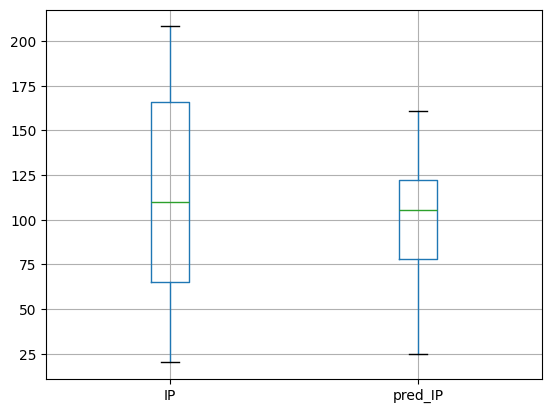

In [182]:
actuals_preds2024[["IP", "pred_IP"]].boxplot()

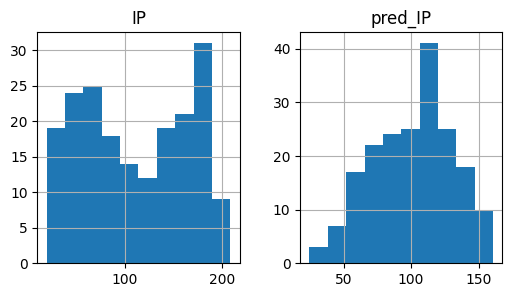

In [183]:
actuals_preds2024[["IP", "pred_IP"]].hist(bins=10, figsize=(6,3))
plt.show()

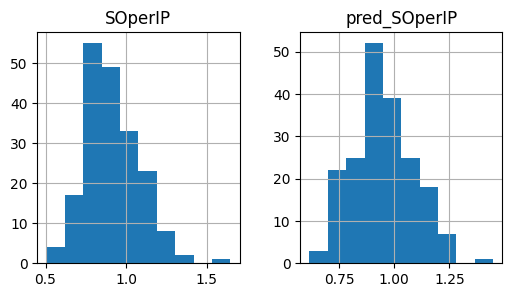

In [184]:
actuals_preds2024[["SOperIP", "pred_SOperIP"]].hist(bins=10, figsize=(6,3))
plt.show()

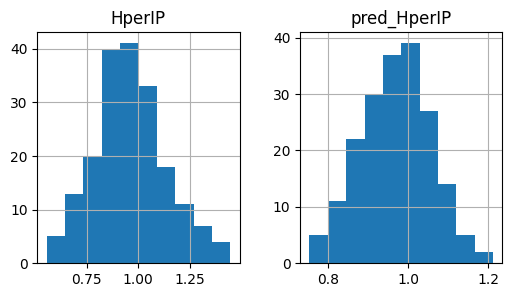

In [185]:
actuals_preds2024[["HperIP", "pred_HperIP"]].hist(bins=10, figsize=(6,3))
plt.show()

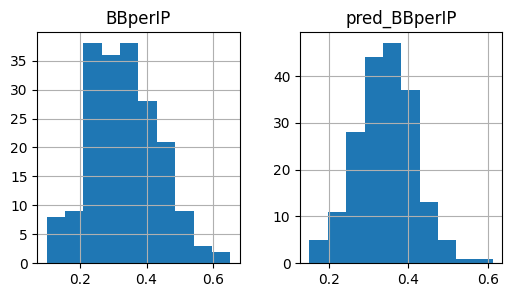

In [186]:
actuals_preds2024[["BBperIP", "pred_BBperIP"]].hist(bins=10, figsize=(6,3))
plt.show()

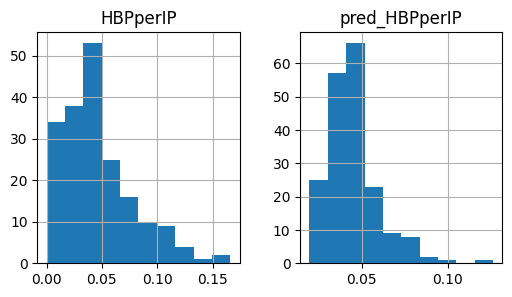

In [187]:
actuals_preds2024[["HBPperIP", "pred_HBPperIP"]].hist(bins=10, figsize=(6,3))
plt.show()

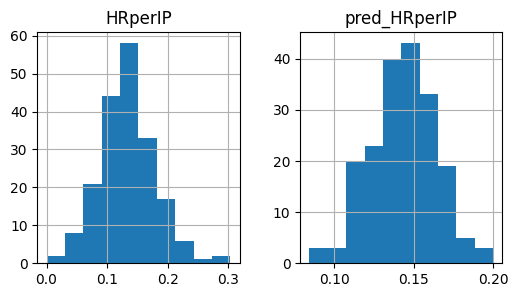

In [188]:
actuals_preds2024[["HRperIP", "pred_HRperIP"]].hist(bins=10, figsize=(6,3))
plt.show()

### 2024 Projected Stat Leaders

#### Innings Pitched (IP)

In [189]:
actuals_preds2024.sort_values('pred_IP', ascending=False).head(5)[['Name','IP', 'pred_IP']]

,,Name,IP,pred_IP
PlayerId,Season,,,
13743,2024,Max Fried,174.1,160.815794
10310,2024,Zack Wheeler,200.0,156.346054
19361,2024,Corbin Burnes,194.1,155.474174
13125,2024,Gerrit Cole,95.0,155.286897
17995,2024,Logan Webb,204.2,151.628799


#### SO/IP

In [190]:
actuals_preds2024.sort_values('SOperIP', ascending=False).head(5)[['Name','SOperIP', 'pred_SOperIP']]

,,Name,SOperIP,pred_SOperIP
PlayerId,Season,,,
7048,2024,Fernando Cruz,1.646526,1.448552
13543,2024,Blake Snell,1.394231,1.249790
24586,2024,Kyle Bradish,1.355499,0.975454
10603,2024,Chris Sale,1.269752,1.248599
14374,2024,Tyler Glasnow,1.253731,1.262609


In [191]:
actuals_preds2024.sort_values('pred_SOperIP', ascending=False).head(5)[['Name','SOperIP', 'pred_SOperIP']]

,,Name,SOperIP,pred_SOperIP
PlayerId,Season,,,
7048,2024,Fernando Cruz,1.646526,1.448552
14374,2024,Tyler Glasnow,1.253731,1.262609
13543,2024,Blake Snell,1.394231,1.249790
10603,2024,Chris Sale,1.269752,1.248599
3137,2024,Max Scherzer,0.928074,1.223670


#### H/IP

In [192]:
# Actual HperIP leaders 
actuals_preds2024.sort_values('HperIP', ascending=True).head(10)[['Name','IP', 'HperIP', 'pred_HperIP']]

,,Name,IP,HperIP,pred_HperIP
PlayerId,Season,,,,
23313,2024,José Buttó,74.0,0.554054,0.840390
26231,2024,Tyler Holton,94.1,0.605739,0.880577
20423,2024,Ryan Walker,80.0,0.625000,0.789341
13543,2024,Blake Snell,104.0,0.625000,0.754520
22182,2024,Hunter Greene,150.1,0.639574,0.764718
21537,2024,Daniel Lynch IV,43.1,0.672854,1.013607
19309,2024,Trevor Richards,65.1,0.675883,0.864681
23150,2024,Osvaldo Bido,63.1,0.681458,0.903074
19407,2024,Ronel Blanco,167.1,0.682226,0.813467


In [193]:
# Predicted HperIP leaders 
actuals_preds2024.sort_values('pred_HperIP', ascending=True).head(10)[['Name','pred_IP', 'HperIP', 'pred_HperIP']]

,,Name,pred_IP,HperIP,pred_HperIP
PlayerId,Season,,,,
13543,2024,Blake Snell,128.303851,0.625000,0.754520
22182,2024,Hunter Greene,124.341695,0.639574,0.764718
26378,2024,Nick Lodolo,129.149429,0.877498,0.776592
14374,2024,Tyler Glasnow,99.479471,0.686567,0.777644
20423,2024,Ryan Walker,82.448539,0.625000,0.789341
10603,2024,Chris Sale,148.006413,0.795711,0.803164
7048,2024,Fernando Cruz,67.984333,0.815710,0.812559
19407,2024,Ronel Blanco,115.263667,0.682226,0.813467
21846,2024,Cole Ragans,135.073850,0.784524,0.815009


#### BB/IP

In [194]:
# Actual BBperIP leaders 
actuals_preds2024.sort_values('BBperIP', ascending=True).head(10)[['Name','IP', 'BBperIP', 'pred_BBperIP']]

,,Name,IP,BBperIP,pred_BBperIP
PlayerId,Season,,,,
16269,2024,John Means,20.2,0.099010,0.165402
30279,2024,Bryan Woo,121.1,0.107349,0.231738
21844,2024,Braxton Garrett,37.0,0.108108,0.231149
13619,2024,Jakob Junis,67.0,0.119403,0.296766
25436,2024,George Kirby,191.0,0.120419,0.151402
12730,2024,Nick Martinez,142.1,0.126671,0.248715
13774,2024,Zach Eflin,165.1,0.145366,0.177628
9803,2024,Miles Mikolas,171.2,0.146028,0.221113
25595,2024,Xzavion Curry,42.2,0.165877,0.339284


In [195]:
# Predicted BBperIP leaders 
actuals_preds2024.sort_values('pred_BBperIP', ascending=True).head(10)[['Name','pred_IP', 'BBperIP', 'pred_BBperIP']]

,,Name,pred_IP,BBperIP,pred_BBperIP
PlayerId,Season,,,,
25436,2024,George Kirby,141.727001,0.120419,0.151402
16269,2024,John Means,71.364114,0.099010,0.165402
13774,2024,Zach Eflin,118.747776,0.145366,0.177628
17735,2024,Tyler Alexander,64.721184,0.223881,0.189876
17995,2024,Logan Webb,151.628799,0.244858,0.196731
15823,2024,Zack Littell,106.940533,0.198591,0.210986
27597,2024,Cody Bradford,55.541528,0.170828,0.218882
9803,2024,Miles Mikolas,122.010167,0.146028,0.221113
26231,2024,Tyler Holton,63.689841,0.180659,0.225201


#### HBP/IP

In [196]:
# Pitchers who hit the most batters in 2024
actuals_preds2024.sort_values('HBPperIP', ascending=False).head(10)[['Name','IP', 'HBPperIP', 'pred_HBPperIP']]


,,Name,IP,HBPperIP,pred_HBPperIP
PlayerId,Season,,,,
26410,2024,Alek Manoah,24.1,0.165975,0.086684
26378,2024,Nick Lodolo,115.1,0.156386,0.126331
21844,2024,Braxton Garrett,37.0,0.135135,0.058859
13781,2024,Alex Wood,39.1,0.127877,0.066072
22182,2024,Hunter Greene,150.1,0.126582,0.079649
23221,2024,Michael Grove,51.0,0.117647,0.041268
16835,2024,Brennan Bernardino,51.0,0.117647,0.093220
14975,2024,Chad Kuhl,53.1,0.112994,0.055897
20423,2024,Ryan Walker,80.0,0.112500,0.074022


In [202]:
# Pitchers who were predicted to hit the most batters 
actuals_preds2024.sort_values('pred_HBPperIP', ascending=False).head(10)[['Name','pred_IP', 'HBPperIP', 'pred_HBPperIP']]


,,Name,pred_IP,HBPperIP,pred_HBPperIP
PlayerId,Season,,,,
26378,2024,Nick Lodolo,129.149429,0.156386,0.126331
23150,2024,Osvaldo Bido,71.503751,0.110935,0.095441
16835,2024,Brennan Bernardino,40.414765,0.117647,0.093220
26410,2024,Alek Manoah,114.993200,0.165975,0.086684
4676,2024,Charlie Morton,119.193440,0.109025,0.080593
22182,2024,Hunter Greene,124.341695,0.126582,0.079649
27451,2024,Alec Marsh,104.555995,0.085271,0.079242
18674,2024,Jake Woodford,56.598379,0.085714,0.078884
23429,2024,JP Sears,116.348036,0.077691,0.075485


#### HR/IP

In [204]:
# Actual HRperIP leaders 
actuals_preds2024.sort_values('HRperIP', ascending=True).head(10)[['Name','IP', 'HRperIP', 'pred_HRperIP']]

,,Name,IP,HRperIP,pred_HRperIP
PlayerId,Season,,,,
25385,2024,Drew Rasmussen,28.2,0.000000,0.084385
14857,2024,Joe Mantiply,59.2,0.016892,0.106752
16977,2024,Trevor Williams,66.2,0.045317,0.159497
23150,2024,Osvaldo Bido,63.1,0.047544,0.111783
10603,2024,Chris Sale,177.2,0.050790,0.131839
24586,2024,Kyle Bradish,39.1,0.051151,0.109093
17995,2024,Logan Webb,204.2,0.053869,0.110691
13543,2024,Blake Snell,104.0,0.057692,0.116911
27572,2024,Carmen Mlodzinski,50.2,0.059761,0.109011


In [203]:
# Predicted HRperIP leaders 
actuals_preds2024.sort_values('pred_HRperIP', ascending=True).head(10)[['Name','pred_IP', 'HRperIP', 'pred_HRperIP']]

,,Name,pred_IP,HRperIP,pred_HRperIP
PlayerId,Season,,,,
25385,2024,Drew Rasmussen,130.918056,0.000000,0.084385
20423,2024,Ryan Walker,82.448539,0.062500,0.089455
13743,2024,Max Fried,160.815794,0.074670,0.094405
16207,2024,Spencer Turnbull,52.919543,0.110906,0.106209
14857,2024,Joe Mantiply,31.444367,0.016892,0.106752
16835,2024,Brennan Bernardino,40.414765,0.117647,0.106968
21846,2024,Cole Ragans,135.073850,0.080602,0.107889
26378,2024,Nick Lodolo,129.149429,0.112945,0.108212
21690,2024,Edward Cabrera,76.831187,0.156087,0.108502


In [ ]:
# Actual HRperIP leaders (worst)
actuals_preds2024.sort_values('HRperIP', ascending=False).head(10)[['Name','IP', 'HRperIP', 'pred_HRperIP']]

,,Name,IP,HRperIP,pred_HRperIP
PlayerId,Season,,,,
27483,2024,Bobby Miller,56.0,0.303571,0.112209
11836,2024,Taijuan Walker,83.2,0.288462,0.154485
27691,2024,Louis Varland,49.2,0.243902,0.172448
14361,2024,Ty Blach,71.1,0.239100,0.146335
26285,2024,Tommy Henry,38.1,0.236220,0.165584
16401,2024,Yonny Chirinos,30.0,0.233333,0.147451
27589,2024,Logan Allen,97.1,0.226571,0.145950
15734,2024,Brad Keller,41.1,0.218978,0.122053
17735,2024,Tyler Alexander,107.2,0.214552,0.170386


In [207]:
# Predicted HRperIP leaders (worst)
actuals_preds2024.sort_values('pred_HRperIP', ascending=False).head(10)[['Name','pred_IP', 'HRperIP', 'pred_HRperIP']]

,,Name,pred_IP,HRperIP,pred_HRperIP
PlayerId,Season,,,,
16269,2024,John Means,71.364114,0.099010,0.199809
22288,2024,Mason Englert,24.586789,0.188679,0.195549
14771,2024,Emilio Pagán,51.015085,0.157895,0.194298
17969,2024,Peter Lambert,51.954165,0.114566,0.186470
17874,2024,Nestor Cortes,88.416325,0.137852,0.182472
23429,2024,JP Sears,116.348036,0.155383,0.181190
21390,2024,Joe Ryan,115.791255,0.140741,0.178700
19911,2024,José Suarez,67.585819,0.134357,0.177686
27581,2024,Hayden Wesneski,70.395945,0.178571,0.175576


### Export projections

In [199]:
predictions2024.to_csv('projections2024.csv', index=True)